In [1]:
# install: tqdm (progress bars)
!pip install tqdm
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import matplotlib.pyplot as plt

You should consider upgrading via the 'pip install --upgrade pip' command.


## Load the data (CIFAR-10)

In [2]:
def load_cifar(datadir='./data_cache'): # will download ~400MB of data into this dir. Change the dir if neccesary. If using paperspace, you can make this /storage
    train_ds = ds.CIFAR10(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.CIFAR10(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=4, pin_memory=True)

X_tr, Y_tr, X_te, Y_te = load_cifar()
X_te_flipped = torch.flip(X_te, [2, 3])
train_dl = make_loader(TensorDataset(X_tr, Y_tr), batch_size=64)
test_dl = make_loader(TensorDataset(X_te, Y_te), batch_size=64)
flipped_test_dl = make_loader(TensorDataset(X_te_flipped, Y_te), batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


## Training helper functions

In [3]:
def train_epoch(model, train_dl : DataLoader, opt, k = 50):
    ''' Trains model for one epoch on the provided dataloader, with optimizer opt. Logs stats every k batches.'''
    loss_func = nn.CrossEntropyLoss()
    model.train()
    model.cuda()

    netLoss = 0.0
    nCorrect = 0
    nTotal = 0
    for i, (xB, yB) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        xB, yB = xB.cuda(), yB.cuda()
        outputs = model(xB)
        loss = loss_func(outputs, yB)
        loss.backward()
        opt.step()
        netLoss += loss.item() * len(xB)
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
        
        if (i+1) % k == 0:
            train_acc = nCorrect/nTotal
            avg_loss = netLoss/nTotal
            print(f'\t [Batch {i+1} / {len(train_dl)}] Train Loss: {avg_loss:.3f} \t Train Acc: {train_acc:.3f}')
  
    train_acc = nCorrect/nTotal
    avg_loss = netLoss/nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc'''
    model.eval()
    model.cuda()
    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc

In [7]:
## Define model

In [4]:
## 5-Layer CNN for CIFAR
## This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def make_cnn(c=64, num_classes=10):
    ''' Returns a 5-layer CNN with width parameter c. '''
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [9]:
## Train

In [48]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 20
test_scores = []
flipped_test_scores = []
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate(model, test_dl)
    flipped_test_loss, flipped_test_acc = evaluate(model, flipped_test_dl)
    test_scores.append(test_acc)
    flipped_test_scores.append(flipped_test_acc)
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')

Starting Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 6.340 	 Train Acc: 0.153
	 [Batch 100 / 391] Train Loss: 4.578 	 Train Acc: 0.184
	 [Batch 150 / 391] Train Loss: 3.756 	 Train Acc: 0.214
	 [Batch 200 / 391] Train Loss: 3.309 	 Train Acc: 0.237
	 [Batch 250 / 391] Train Loss: 3.017 	 Train Acc: 0.258
	 [Batch 300 / 391] Train Loss: 2.802 	 Train Acc: 0.277
	 [Batch 350 / 391] Train Loss: 2.641 	 Train Acc: 0.294
Epoch 0:	 Train Loss: 2.533 	 Train Acc: 0.307	 Test Acc: 0.378
Starting Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.531 	 Train Acc: 0.436
	 [Batch 100 / 391] Train Loss: 1.498 	 Train Acc: 0.454
	 [Batch 150 / 391] Train Loss: 1.465 	 Train Acc: 0.469
	 [Batch 200 / 391] Train Loss: 1.442 	 Train Acc: 0.478
	 [Batch 250 / 391] Train Loss: 1.417 	 Train Acc: 0.487
	 [Batch 300 / 391] Train Loss: 1.395 	 Train Acc: 0.497
	 [Batch 350 / 391] Train Loss: 1.379 	 Train Acc: 0.504
Epoch 1:	 Train Loss: 1.364 	 Train Acc: 0.509	 Test Acc: 0.466
Starting Epoch 2


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.151 	 Train Acc: 0.590
	 [Batch 100 / 391] Train Loss: 1.153 	 Train Acc: 0.589
	 [Batch 150 / 391] Train Loss: 1.128 	 Train Acc: 0.598
	 [Batch 200 / 391] Train Loss: 1.124 	 Train Acc: 0.600
	 [Batch 250 / 391] Train Loss: 1.107 	 Train Acc: 0.608
	 [Batch 300 / 391] Train Loss: 1.092 	 Train Acc: 0.614
	 [Batch 350 / 391] Train Loss: 1.078 	 Train Acc: 0.619
Epoch 2:	 Train Loss: 1.074 	 Train Acc: 0.621	 Test Acc: 0.614
Starting Epoch 3


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.939 	 Train Acc: 0.673
	 [Batch 100 / 391] Train Loss: 0.939 	 Train Acc: 0.673
	 [Batch 150 / 391] Train Loss: 0.925 	 Train Acc: 0.678
	 [Batch 200 / 391] Train Loss: 0.914 	 Train Acc: 0.682
	 [Batch 250 / 391] Train Loss: 0.907 	 Train Acc: 0.684
	 [Batch 300 / 391] Train Loss: 0.903 	 Train Acc: 0.686
	 [Batch 350 / 391] Train Loss: 0.899 	 Train Acc: 0.687
Epoch 3:	 Train Loss: 0.889 	 Train Acc: 0.690	 Test Acc: 0.566
Starting Epoch 4


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.816 	 Train Acc: 0.715
	 [Batch 100 / 391] Train Loss: 0.773 	 Train Acc: 0.732
	 [Batch 150 / 391] Train Loss: 0.767 	 Train Acc: 0.732
	 [Batch 200 / 391] Train Loss: 0.764 	 Train Acc: 0.732
	 [Batch 250 / 391] Train Loss: 0.763 	 Train Acc: 0.733
	 [Batch 300 / 391] Train Loss: 0.757 	 Train Acc: 0.736
	 [Batch 350 / 391] Train Loss: 0.755 	 Train Acc: 0.737
Epoch 4:	 Train Loss: 0.755 	 Train Acc: 0.737	 Test Acc: 0.730
Starting Epoch 5


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.609 	 Train Acc: 0.792
	 [Batch 100 / 391] Train Loss: 0.645 	 Train Acc: 0.780
	 [Batch 150 / 391] Train Loss: 0.642 	 Train Acc: 0.780
	 [Batch 200 / 391] Train Loss: 0.644 	 Train Acc: 0.778
	 [Batch 250 / 391] Train Loss: 0.636 	 Train Acc: 0.780
	 [Batch 300 / 391] Train Loss: 0.646 	 Train Acc: 0.777
	 [Batch 350 / 391] Train Loss: 0.643 	 Train Acc: 0.779
Epoch 5:	 Train Loss: 0.639 	 Train Acc: 0.780	 Test Acc: 0.713
Starting Epoch 6


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.547 	 Train Acc: 0.815
	 [Batch 100 / 391] Train Loss: 0.547 	 Train Acc: 0.813
	 [Batch 150 / 391] Train Loss: 0.553 	 Train Acc: 0.811
	 [Batch 200 / 391] Train Loss: 0.543 	 Train Acc: 0.815
	 [Batch 250 / 391] Train Loss: 0.551 	 Train Acc: 0.813
	 [Batch 300 / 391] Train Loss: 0.546 	 Train Acc: 0.814
	 [Batch 350 / 391] Train Loss: 0.547 	 Train Acc: 0.814
Epoch 6:	 Train Loss: 0.546 	 Train Acc: 0.814	 Test Acc: 0.617
Starting Epoch 7


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.442 	 Train Acc: 0.850
	 [Batch 100 / 391] Train Loss: 0.462 	 Train Acc: 0.841
	 [Batch 150 / 391] Train Loss: 0.468 	 Train Acc: 0.841
	 [Batch 200 / 391] Train Loss: 0.477 	 Train Acc: 0.839
	 [Batch 250 / 391] Train Loss: 0.481 	 Train Acc: 0.837
	 [Batch 300 / 391] Train Loss: 0.477 	 Train Acc: 0.838
	 [Batch 350 / 391] Train Loss: 0.482 	 Train Acc: 0.837
Epoch 7:	 Train Loss: 0.483 	 Train Acc: 0.837	 Test Acc: 0.735
Starting Epoch 8


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.367 	 Train Acc: 0.873
	 [Batch 100 / 391] Train Loss: 0.392 	 Train Acc: 0.869
	 [Batch 150 / 391] Train Loss: 0.393 	 Train Acc: 0.868
	 [Batch 200 / 391] Train Loss: 0.398 	 Train Acc: 0.865
	 [Batch 250 / 391] Train Loss: 0.400 	 Train Acc: 0.863
	 [Batch 300 / 391] Train Loss: 0.402 	 Train Acc: 0.863
	 [Batch 350 / 391] Train Loss: 0.399 	 Train Acc: 0.864
Epoch 8:	 Train Loss: 0.403 	 Train Acc: 0.862	 Test Acc: 0.710
Starting Epoch 9


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.318 	 Train Acc: 0.895
	 [Batch 100 / 391] Train Loss: 0.317 	 Train Acc: 0.892
	 [Batch 150 / 391] Train Loss: 0.322 	 Train Acc: 0.891
	 [Batch 200 / 391] Train Loss: 0.320 	 Train Acc: 0.893
	 [Batch 250 / 391] Train Loss: 0.333 	 Train Acc: 0.888
	 [Batch 300 / 391] Train Loss: 0.337 	 Train Acc: 0.887
	 [Batch 350 / 391] Train Loss: 0.339 	 Train Acc: 0.887
Epoch 9:	 Train Loss: 0.343 	 Train Acc: 0.887	 Test Acc: 0.783
Starting Epoch 10


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.238 	 Train Acc: 0.921
	 [Batch 100 / 391] Train Loss: 0.247 	 Train Acc: 0.918
	 [Batch 150 / 391] Train Loss: 0.278 	 Train Acc: 0.913
	 [Batch 200 / 391] Train Loss: 0.271 	 Train Acc: 0.913
	 [Batch 250 / 391] Train Loss: 0.264 	 Train Acc: 0.914
	 [Batch 300 / 391] Train Loss: 0.273 	 Train Acc: 0.912
	 [Batch 350 / 391] Train Loss: 0.275 	 Train Acc: 0.910
Epoch 10:	 Train Loss: 0.278 	 Train Acc: 0.909	 Test Acc: 0.776
Starting Epoch 11


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.155 	 Train Acc: 0.948
	 [Batch 100 / 391] Train Loss: 0.188 	 Train Acc: 0.939
	 [Batch 150 / 391] Train Loss: 0.218 	 Train Acc: 0.933
	 [Batch 200 / 391] Train Loss: 0.212 	 Train Acc: 0.934
	 [Batch 250 / 391] Train Loss: 0.211 	 Train Acc: 0.933
	 [Batch 300 / 391] Train Loss: 0.219 	 Train Acc: 0.931
	 [Batch 350 / 391] Train Loss: 0.218 	 Train Acc: 0.930
Epoch 11:	 Train Loss: 0.218 	 Train Acc: 0.930	 Test Acc: 0.783
Starting Epoch 12


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.127 	 Train Acc: 0.961
	 [Batch 100 / 391] Train Loss: 0.163 	 Train Acc: 0.956
	 [Batch 150 / 391] Train Loss: 0.165 	 Train Acc: 0.952
	 [Batch 200 / 391] Train Loss: 0.168 	 Train Acc: 0.949
	 [Batch 250 / 391] Train Loss: 0.162 	 Train Acc: 0.952
	 [Batch 300 / 391] Train Loss: 0.158 	 Train Acc: 0.953
	 [Batch 350 / 391] Train Loss: 0.160 	 Train Acc: 0.951
Epoch 12:	 Train Loss: 0.162 	 Train Acc: 0.950	 Test Acc: 0.820
Starting Epoch 13


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.055 	 Train Acc: 0.985
	 [Batch 100 / 391] Train Loss: 0.078 	 Train Acc: 0.979
	 [Batch 150 / 391] Train Loss: 0.076 	 Train Acc: 0.979
	 [Batch 200 / 391] Train Loss: 0.080 	 Train Acc: 0.978
	 [Batch 250 / 391] Train Loss: 0.096 	 Train Acc: 0.975
	 [Batch 300 / 391] Train Loss: 0.102 	 Train Acc: 0.973
	 [Batch 350 / 391] Train Loss: 0.102 	 Train Acc: 0.973
Epoch 13:	 Train Loss: 0.111 	 Train Acc: 0.970	 Test Acc: 0.800
Starting Epoch 14


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.045 	 Train Acc: 0.990
	 [Batch 100 / 391] Train Loss: 0.039 	 Train Acc: 0.992
	 [Batch 150 / 391] Train Loss: 0.040 	 Train Acc: 0.991
	 [Batch 200 / 391] Train Loss: 0.037 	 Train Acc: 0.992
	 [Batch 250 / 391] Train Loss: 0.035 	 Train Acc: 0.992
	 [Batch 300 / 391] Train Loss: 0.034 	 Train Acc: 0.993
	 [Batch 350 / 391] Train Loss: 0.033 	 Train Acc: 0.993
Epoch 14:	 Train Loss: 0.033 	 Train Acc: 0.993	 Test Acc: 0.837
Starting Epoch 15


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.012 	 Train Acc: 0.999
	 [Batch 100 / 391] Train Loss: 0.011 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 200 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 250 / 391] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 300 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 350 / 391] Train Loss: 0.011 	 Train Acc: 0.999
Epoch 15:	 Train Loss: 0.011 	 Train Acc: 0.999	 Test Acc: 0.850
Starting Epoch 16


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.005 	 Train Acc: 1.000
Epoch 16:	 Train Loss: 0.005 	 Train Acc: 1.000	 Test Acc: 0.854
Starting Epoch 17


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.003 	 Train Acc: 1.000	 Test Acc: 0.855
Starting Epoch 18


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.856
Starting Epoch 19


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.858


### Flipped images

##### Human visualization

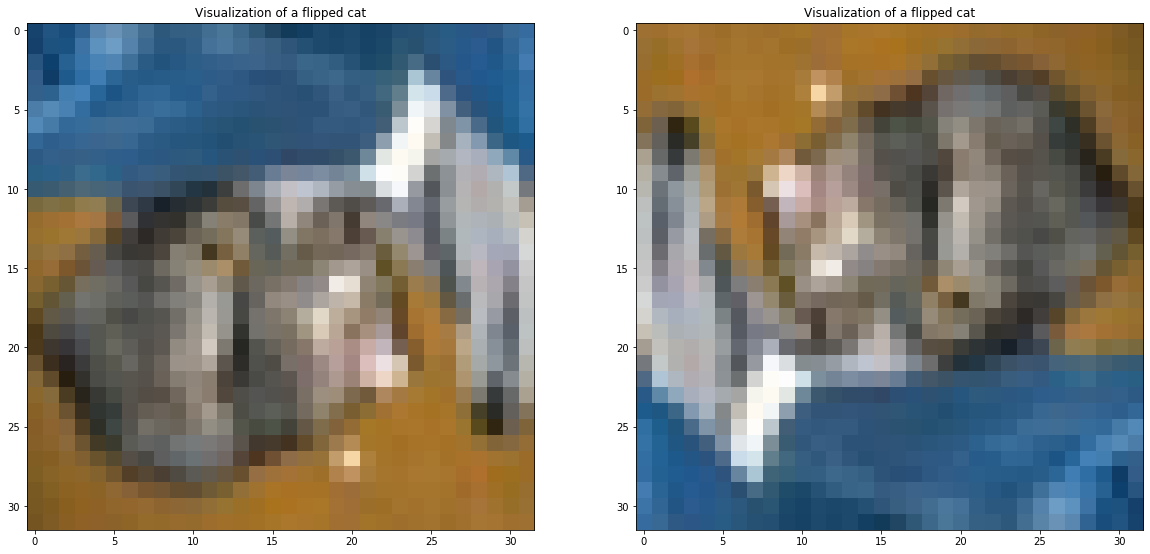

In [6]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
non_flipped_cat = X_te[Y_te == 3][0]
flipped_cat = X_te_flipped[Y_te == 3][0]
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
axes[0].imshow(flipped_cat.permute((1, 2, 0)))
axes[0].set_title('Visualization of a flipped cat')
axes[1].imshow(non_flipped_cat.permute((1, 2, 0)))
axes[1].set_title('Visualization of a flipped cat')
plt.savefig('Flipped_unflipped_cat.png')
plt.show(fig)

##### Test performances: 20 epochs

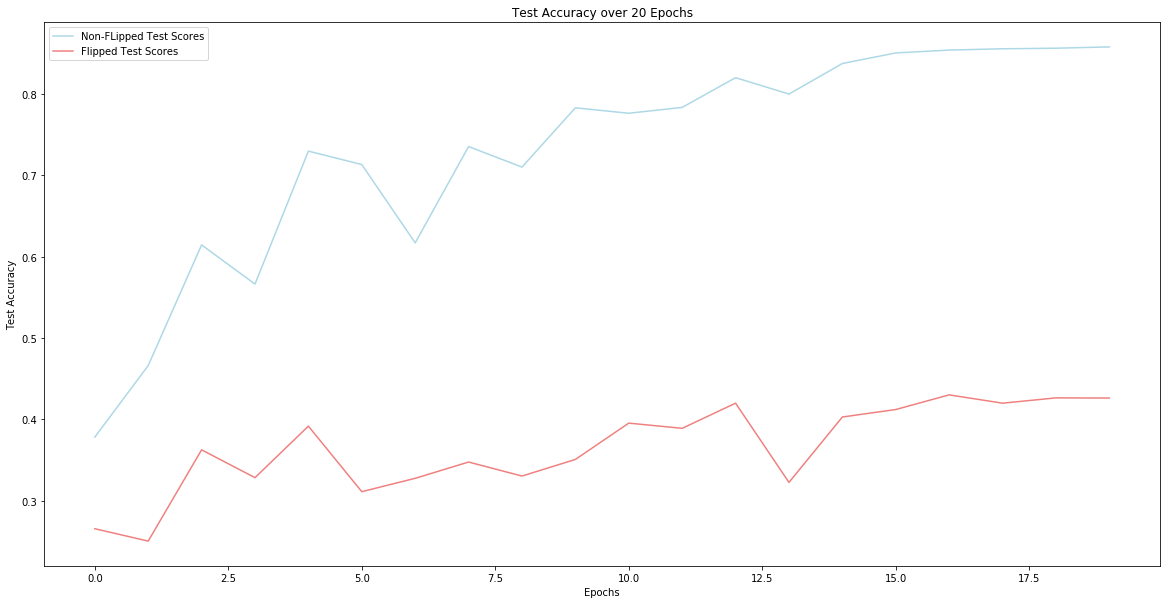

In [55]:
fig = plt.figure(figsize = (20, 10))
plt.plot(test_scores, color= 'lightblue', label='Non-FLipped Test Scores')
plt.plot(flipped_test_scores, color='lightcoral', label='Flipped Test Scores')
plt.title('Test Accuracy over 20 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('Performances_after_20_epochs.png')
plt.show(fig)

##### Test performances: 80 epochs

Let's see what happens when we train our model for several more epochs. What is good with the Cross Entropy training loss, it's that we can keep on trainijng even though our training accuracy is perfect (we deal with probabilities and not with labels).

Starting Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 4.791 	 Train Acc: 0.163
	 [Batch 100 / 391] Train Loss: 3.453 	 Train Acc: 0.189
	 [Batch 150 / 391] Train Loss: 2.966 	 Train Acc: 0.215
	 [Batch 200 / 391] Train Loss: 2.696 	 Train Acc: 0.238
	 [Batch 250 / 391] Train Loss: 2.520 	 Train Acc: 0.257
	 [Batch 300 / 391] Train Loss: 2.389 	 Train Acc: 0.275
	 [Batch 350 / 391] Train Loss: 2.285 	 Train Acc: 0.292
Epoch 0:	 Train Loss: 2.213 	 Train Acc: 0.305	 Test Acc: 0.408
Starting Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.550 	 Train Acc: 0.431
	 [Batch 100 / 391] Train Loss: 1.516 	 Train Acc: 0.449
	 [Batch 150 / 391] Train Loss: 1.497 	 Train Acc: 0.456
	 [Batch 200 / 391] Train Loss: 1.475 	 Train Acc: 0.464
	 [Batch 250 / 391] Train Loss: 1.457 	 Train Acc: 0.471
	 [Batch 300 / 391] Train Loss: 1.428 	 Train Acc: 0.481
	 [Batch 350 / 391] Train Loss: 1.408 	 Train Acc: 0.489
Epoch 1:	 Train Loss: 1.391 	 Train Acc: 0.496	 Test Acc: 0.498
Starting Epoch 2


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.227 	 Train Acc: 0.562
	 [Batch 100 / 391] Train Loss: 1.220 	 Train Acc: 0.567
	 [Batch 150 / 391] Train Loss: 1.193 	 Train Acc: 0.573
	 [Batch 200 / 391] Train Loss: 1.175 	 Train Acc: 0.580
	 [Batch 250 / 391] Train Loss: 1.162 	 Train Acc: 0.585
	 [Batch 300 / 391] Train Loss: 1.148 	 Train Acc: 0.589
	 [Batch 350 / 391] Train Loss: 1.137 	 Train Acc: 0.594
Epoch 2:	 Train Loss: 1.125 	 Train Acc: 0.599	 Test Acc: 0.537
Starting Epoch 3


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.962 	 Train Acc: 0.658
	 [Batch 100 / 391] Train Loss: 0.965 	 Train Acc: 0.659
	 [Batch 150 / 391] Train Loss: 0.975 	 Train Acc: 0.657
	 [Batch 200 / 391] Train Loss: 0.962 	 Train Acc: 0.663
	 [Batch 250 / 391] Train Loss: 0.956 	 Train Acc: 0.665
	 [Batch 300 / 391] Train Loss: 0.945 	 Train Acc: 0.669
	 [Batch 350 / 391] Train Loss: 0.929 	 Train Acc: 0.675
Epoch 3:	 Train Loss: 0.923 	 Train Acc: 0.677	 Test Acc: 0.639
Starting Epoch 4


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.814 	 Train Acc: 0.713
	 [Batch 100 / 391] Train Loss: 0.790 	 Train Acc: 0.724
	 [Batch 150 / 391] Train Loss: 0.791 	 Train Acc: 0.726
	 [Batch 200 / 391] Train Loss: 0.788 	 Train Acc: 0.727
	 [Batch 250 / 391] Train Loss: 0.794 	 Train Acc: 0.725
	 [Batch 300 / 391] Train Loss: 0.788 	 Train Acc: 0.728
	 [Batch 350 / 391] Train Loss: 0.779 	 Train Acc: 0.732
Epoch 4:	 Train Loss: 0.776 	 Train Acc: 0.733	 Test Acc: 0.610
Starting Epoch 5


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.680 	 Train Acc: 0.767
	 [Batch 100 / 391] Train Loss: 0.692 	 Train Acc: 0.764
	 [Batch 150 / 391] Train Loss: 0.690 	 Train Acc: 0.765
	 [Batch 200 / 391] Train Loss: 0.688 	 Train Acc: 0.764
	 [Batch 250 / 391] Train Loss: 0.688 	 Train Acc: 0.764
	 [Batch 300 / 391] Train Loss: 0.679 	 Train Acc: 0.766
	 [Batch 350 / 391] Train Loss: 0.672 	 Train Acc: 0.769
Epoch 5:	 Train Loss: 0.669 	 Train Acc: 0.769	 Test Acc: 0.709
Starting Epoch 6


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.588 	 Train Acc: 0.797
	 [Batch 100 / 391] Train Loss: 0.564 	 Train Acc: 0.807
	 [Batch 150 / 391] Train Loss: 0.565 	 Train Acc: 0.807
	 [Batch 200 / 391] Train Loss: 0.573 	 Train Acc: 0.805
	 [Batch 250 / 391] Train Loss: 0.568 	 Train Acc: 0.806
	 [Batch 300 / 391] Train Loss: 0.571 	 Train Acc: 0.805
	 [Batch 350 / 391] Train Loss: 0.570 	 Train Acc: 0.806
Epoch 6:	 Train Loss: 0.566 	 Train Acc: 0.807	 Test Acc: 0.763
Starting Epoch 7


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.456 	 Train Acc: 0.845
	 [Batch 100 / 391] Train Loss: 0.483 	 Train Acc: 0.834
	 [Batch 150 / 391] Train Loss: 0.484 	 Train Acc: 0.836
	 [Batch 200 / 391] Train Loss: 0.490 	 Train Acc: 0.834
	 [Batch 250 / 391] Train Loss: 0.484 	 Train Acc: 0.835
	 [Batch 300 / 391] Train Loss: 0.493 	 Train Acc: 0.833
	 [Batch 350 / 391] Train Loss: 0.496 	 Train Acc: 0.831
Epoch 7:	 Train Loss: 0.497 	 Train Acc: 0.831	 Test Acc: 0.740
Starting Epoch 8


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.376 	 Train Acc: 0.871
	 [Batch 100 / 391] Train Loss: 0.382 	 Train Acc: 0.869
	 [Batch 150 / 391] Train Loss: 0.397 	 Train Acc: 0.867
	 [Batch 200 / 391] Train Loss: 0.412 	 Train Acc: 0.862
	 [Batch 250 / 391] Train Loss: 0.412 	 Train Acc: 0.862
	 [Batch 300 / 391] Train Loss: 0.410 	 Train Acc: 0.862
	 [Batch 350 / 391] Train Loss: 0.421 	 Train Acc: 0.859
Epoch 8:	 Train Loss: 0.420 	 Train Acc: 0.858	 Test Acc: 0.737
Starting Epoch 9


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.343 	 Train Acc: 0.886
	 [Batch 100 / 391] Train Loss: 0.349 	 Train Acc: 0.886
	 [Batch 150 / 391] Train Loss: 0.356 	 Train Acc: 0.883
	 [Batch 200 / 391] Train Loss: 0.338 	 Train Acc: 0.888
	 [Batch 250 / 391] Train Loss: 0.359 	 Train Acc: 0.882
	 [Batch 300 / 391] Train Loss: 0.362 	 Train Acc: 0.882
	 [Batch 350 / 391] Train Loss: 0.356 	 Train Acc: 0.883
Epoch 9:	 Train Loss: 0.357 	 Train Acc: 0.883	 Test Acc: 0.761
Starting Epoch 10


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.274 	 Train Acc: 0.915
	 [Batch 100 / 391] Train Loss: 0.259 	 Train Acc: 0.915
	 [Batch 150 / 391] Train Loss: 0.285 	 Train Acc: 0.908
	 [Batch 200 / 391] Train Loss: 0.284 	 Train Acc: 0.907
	 [Batch 250 / 391] Train Loss: 0.283 	 Train Acc: 0.908
	 [Batch 300 / 391] Train Loss: 0.282 	 Train Acc: 0.908
	 [Batch 350 / 391] Train Loss: 0.283 	 Train Acc: 0.907
Epoch 10:	 Train Loss: 0.285 	 Train Acc: 0.906	 Test Acc: 0.782
Starting Epoch 11


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.168 	 Train Acc: 0.948
	 [Batch 100 / 391] Train Loss: 0.171 	 Train Acc: 0.946
	 [Batch 150 / 391] Train Loss: 0.192 	 Train Acc: 0.940
	 [Batch 200 / 391] Train Loss: 0.205 	 Train Acc: 0.934
	 [Batch 250 / 391] Train Loss: 0.203 	 Train Acc: 0.934
	 [Batch 300 / 391] Train Loss: 0.207 	 Train Acc: 0.932
	 [Batch 350 / 391] Train Loss: 0.219 	 Train Acc: 0.929
Epoch 11:	 Train Loss: 0.219 	 Train Acc: 0.928	 Test Acc: 0.801
Starting Epoch 12


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.172 	 Train Acc: 0.946
	 [Batch 100 / 391] Train Loss: 0.175 	 Train Acc: 0.946
	 [Batch 150 / 391] Train Loss: 0.166 	 Train Acc: 0.949
	 [Batch 200 / 391] Train Loss: 0.189 	 Train Acc: 0.945
	 [Batch 250 / 391] Train Loss: 0.190 	 Train Acc: 0.943
	 [Batch 300 / 391] Train Loss: 0.201 	 Train Acc: 0.941
	 [Batch 350 / 391] Train Loss: 0.192 	 Train Acc: 0.942
Epoch 12:	 Train Loss: 0.194 	 Train Acc: 0.942	 Test Acc: 0.804
Starting Epoch 13


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.122 	 Train Acc: 0.971
	 [Batch 100 / 391] Train Loss: 0.096 	 Train Acc: 0.975
	 [Batch 150 / 391] Train Loss: 0.096 	 Train Acc: 0.973
	 [Batch 200 / 391] Train Loss: 0.090 	 Train Acc: 0.975
	 [Batch 250 / 391] Train Loss: 0.086 	 Train Acc: 0.976
	 [Batch 300 / 391] Train Loss: 0.099 	 Train Acc: 0.972
	 [Batch 350 / 391] Train Loss: 0.101 	 Train Acc: 0.971
Epoch 13:	 Train Loss: 0.101 	 Train Acc: 0.970	 Test Acc: 0.831
Starting Epoch 14


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.035 	 Train Acc: 0.993
	 [Batch 100 / 391] Train Loss: 0.034 	 Train Acc: 0.993
	 [Batch 150 / 391] Train Loss: 0.037 	 Train Acc: 0.991
	 [Batch 200 / 391] Train Loss: 0.035 	 Train Acc: 0.992
	 [Batch 250 / 391] Train Loss: 0.035 	 Train Acc: 0.992
	 [Batch 300 / 391] Train Loss: 0.035 	 Train Acc: 0.992
	 [Batch 350 / 391] Train Loss: 0.036 	 Train Acc: 0.992
Epoch 14:	 Train Loss: 0.036 	 Train Acc: 0.992	 Test Acc: 0.818
Starting Epoch 15


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.014 	 Train Acc: 0.999
	 [Batch 100 / 391] Train Loss: 0.013 	 Train Acc: 0.999
	 [Batch 150 / 391] Train Loss: 0.012 	 Train Acc: 0.999
	 [Batch 200 / 391] Train Loss: 0.012 	 Train Acc: 0.999
	 [Batch 250 / 391] Train Loss: 0.012 	 Train Acc: 0.999
	 [Batch 300 / 391] Train Loss: 0.012 	 Train Acc: 0.999
	 [Batch 350 / 391] Train Loss: 0.012 	 Train Acc: 0.999
Epoch 15:	 Train Loss: 0.012 	 Train Acc: 0.999	 Test Acc: 0.845
Starting Epoch 16


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.006 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.006 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.006 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.005 	 Train Acc: 1.000
Epoch 16:	 Train Loss: 0.005 	 Train Acc: 1.000	 Test Acc: 0.863
Starting Epoch 17


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.003 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 18


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.864
Starting Epoch 19


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 20


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 20:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 21


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 21:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 22


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 22:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 23


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 23:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 24


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 24:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 25


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 25:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 26


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 26:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 27


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 27:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 28


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 28:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 29


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 29:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 30


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 30:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 31


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 31:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 32


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 32:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 33


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 33:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 34


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 34:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 35


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 35:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 36


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 36:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 37


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 37:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 38


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 38:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 39


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 39:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 40


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 40:	 Train Loss: 0.001 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 41


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 41:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 42


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 42:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 43


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 43:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 44


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 44:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 45


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 45:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 46


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 46:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 47


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 47:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 48


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 48:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 49


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 49:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 50


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 50:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 51


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 51:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 52


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 52:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 53


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 53:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 54


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 54:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 55


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 55:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 56


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 56:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 57


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 57:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 58


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 58:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 59


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 59:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 60


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 60:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 61


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 61:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 62


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 62:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 63


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 63:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 64


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 64:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 65


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 65:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 66


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 66:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 67


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 67:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 68


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 68:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 69


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 69:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 70


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 70:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.865
Starting Epoch 71


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 71:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 72


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 72:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 73


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 73:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 74


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 74:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 75


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 75:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 76


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 76:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.866
Starting Epoch 77


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 77:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 78


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 78:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867
Starting Epoch 79


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 79:	 Train Loss: 0.000 	 Train Acc: 1.000	 Test Acc: 0.867


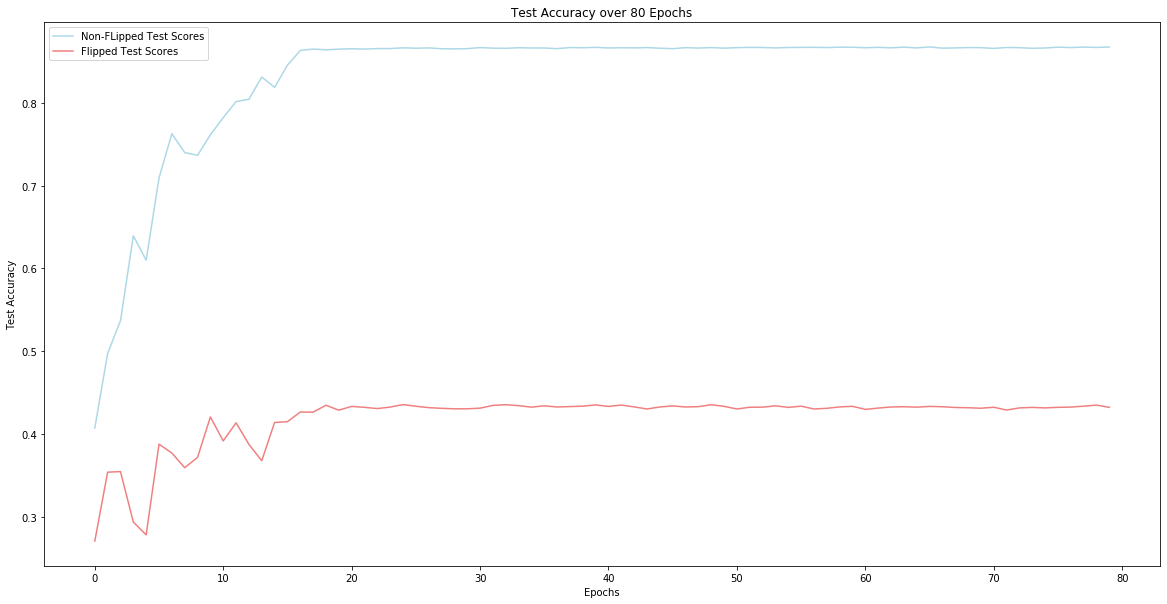

In [56]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 80
test_scores = []
flipped_test_scores = []
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate(model, test_dl)
    flipped_test_loss, flipped_test_acc = evaluate(model, flipped_test_dl)
    test_scores.append(test_acc)
    flipped_test_scores.append(flipped_test_acc)
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')
fig = plt.figure(figsize = (20, 10))
plt.plot(test_scores, color= 'lightblue', label='Non-FLipped Test Scores')
plt.plot(flipped_test_scores, color='lightcoral', label='Flipped Test Scores')
plt.title('Test Accuracy over 80 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('Performances_after_80_epochs.png')
plt.show(fig)

##### Test performances over classes, over epochs: 20 epochs

In [7]:
def evaluate_per_class(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc per class'''
    model.eval()
    model.cuda()
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            for t, p in zip(yb.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            net_loss += loss
            nTotal += preds.size(0)
    acc = (confusion_matrix.diag()/confusion_matrix.sum(1)).numpy()
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc

Starting Epoch 0


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 6.828 	 Train Acc: 0.132
	 [Batch 100 / 782] Train Loss: 4.803 	 Train Acc: 0.164
	 [Batch 150 / 782] Train Loss: 4.036 	 Train Acc: 0.185
	 [Batch 200 / 782] Train Loss: 3.555 	 Train Acc: 0.207
	 [Batch 250 / 782] Train Loss: 3.242 	 Train Acc: 0.228
	 [Batch 300 / 782] Train Loss: 3.017 	 Train Acc: 0.244
	 [Batch 350 / 782] Train Loss: 2.845 	 Train Acc: 0.258
	 [Batch 400 / 782] Train Loss: 2.700 	 Train Acc: 0.274
	 [Batch 450 / 782] Train Loss: 2.580 	 Train Acc: 0.289
	 [Batch 500 / 782] Train Loss: 2.485 	 Train Acc: 0.301
	 [Batch 550 / 782] Train Loss: 2.401 	 Train Acc: 0.314
	 [Batch 600 / 782] Train Loss: 2.323 	 Train Acc: 0.326
	 [Batch 650 / 782] Train Loss: 2.257 	 Train Acc: 0.337
	 [Batch 700 / 782] Train Loss: 2.195 	 Train Acc: 0.348
	 [Batch 750 / 782] Train Loss: 2.139 	 Train Acc: 0.359
Epoch 0:	 Train Loss: 2.107 	 Train Acc: 0.365
Starting Epoch 1


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 1.275 	 Train Acc: 0.549
	 [Batch 100 / 782] Train Loss: 1.268 	 Train Acc: 0.549
	 [Batch 150 / 782] Train Loss: 1.271 	 Train Acc: 0.544
	 [Batch 200 / 782] Train Loss: 1.263 	 Train Acc: 0.548
	 [Batch 250 / 782] Train Loss: 1.243 	 Train Acc: 0.554
	 [Batch 300 / 782] Train Loss: 1.227 	 Train Acc: 0.562
	 [Batch 350 / 782] Train Loss: 1.216 	 Train Acc: 0.565
	 [Batch 400 / 782] Train Loss: 1.204 	 Train Acc: 0.569
	 [Batch 450 / 782] Train Loss: 1.192 	 Train Acc: 0.574
	 [Batch 500 / 782] Train Loss: 1.179 	 Train Acc: 0.577
	 [Batch 550 / 782] Train Loss: 1.166 	 Train Acc: 0.583
	 [Batch 600 / 782] Train Loss: 1.160 	 Train Acc: 0.586
	 [Batch 650 / 782] Train Loss: 1.150 	 Train Acc: 0.590
	 [Batch 700 / 782] Train Loss: 1.141 	 Train Acc: 0.593
	 [Batch 750 / 782] Train Loss: 1.128 	 Train Acc: 0.598
Epoch 1:	 Train Loss: 1.122 	 Train Acc: 0.600
Starting Epoch 2


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.962 	 Train Acc: 0.674
	 [Batch 100 / 782] Train Loss: 0.933 	 Train Acc: 0.680
	 [Batch 150 / 782] Train Loss: 0.933 	 Train Acc: 0.678
	 [Batch 200 / 782] Train Loss: 0.912 	 Train Acc: 0.684
	 [Batch 250 / 782] Train Loss: 0.904 	 Train Acc: 0.687
	 [Batch 300 / 782] Train Loss: 0.900 	 Train Acc: 0.688
	 [Batch 350 / 782] Train Loss: 0.892 	 Train Acc: 0.690
	 [Batch 400 / 782] Train Loss: 0.884 	 Train Acc: 0.692
	 [Batch 450 / 782] Train Loss: 0.887 	 Train Acc: 0.692
	 [Batch 500 / 782] Train Loss: 0.884 	 Train Acc: 0.692
	 [Batch 550 / 782] Train Loss: 0.876 	 Train Acc: 0.695
	 [Batch 600 / 782] Train Loss: 0.867 	 Train Acc: 0.698
	 [Batch 650 / 782] Train Loss: 0.861 	 Train Acc: 0.700
	 [Batch 700 / 782] Train Loss: 0.859 	 Train Acc: 0.701
	 [Batch 750 / 782] Train Loss: 0.853 	 Train Acc: 0.704
Epoch 2:	 Train Loss: 0.848 	 Train Acc: 0.705
Starting Epoch 3


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.722 	 Train Acc: 0.748
	 [Batch 100 / 782] Train Loss: 0.714 	 Train Acc: 0.753
	 [Batch 150 / 782] Train Loss: 0.711 	 Train Acc: 0.751
	 [Batch 200 / 782] Train Loss: 0.703 	 Train Acc: 0.754
	 [Batch 250 / 782] Train Loss: 0.697 	 Train Acc: 0.754
	 [Batch 300 / 782] Train Loss: 0.698 	 Train Acc: 0.754
	 [Batch 350 / 782] Train Loss: 0.694 	 Train Acc: 0.756
	 [Batch 400 / 782] Train Loss: 0.693 	 Train Acc: 0.757
	 [Batch 450 / 782] Train Loss: 0.693 	 Train Acc: 0.758
	 [Batch 500 / 782] Train Loss: 0.690 	 Train Acc: 0.759
	 [Batch 550 / 782] Train Loss: 0.688 	 Train Acc: 0.760
	 [Batch 600 / 782] Train Loss: 0.686 	 Train Acc: 0.761
	 [Batch 650 / 782] Train Loss: 0.686 	 Train Acc: 0.761
	 [Batch 700 / 782] Train Loss: 0.682 	 Train Acc: 0.763
	 [Batch 750 / 782] Train Loss: 0.679 	 Train Acc: 0.764
Epoch 3:	 Train Loss: 0.678 	 Train Acc: 0.764
Starting Epoch 4


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.572 	 Train Acc: 0.808
	 [Batch 100 / 782] Train Loss: 0.580 	 Train Acc: 0.803
	 [Batch 150 / 782] Train Loss: 0.582 	 Train Acc: 0.802
	 [Batch 200 / 782] Train Loss: 0.570 	 Train Acc: 0.806
	 [Batch 250 / 782] Train Loss: 0.572 	 Train Acc: 0.805
	 [Batch 300 / 782] Train Loss: 0.565 	 Train Acc: 0.807
	 [Batch 350 / 782] Train Loss: 0.570 	 Train Acc: 0.806
	 [Batch 400 / 782] Train Loss: 0.572 	 Train Acc: 0.805
	 [Batch 450 / 782] Train Loss: 0.569 	 Train Acc: 0.805
	 [Batch 500 / 782] Train Loss: 0.569 	 Train Acc: 0.806
	 [Batch 550 / 782] Train Loss: 0.570 	 Train Acc: 0.805
	 [Batch 600 / 782] Train Loss: 0.569 	 Train Acc: 0.805
	 [Batch 650 / 782] Train Loss: 0.570 	 Train Acc: 0.804
	 [Batch 700 / 782] Train Loss: 0.570 	 Train Acc: 0.804
	 [Batch 750 / 782] Train Loss: 0.569 	 Train Acc: 0.804
Epoch 4:	 Train Loss: 0.568 	 Train Acc: 0.804
Starting Epoch 5


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.511 	 Train Acc: 0.830
	 [Batch 100 / 782] Train Loss: 0.475 	 Train Acc: 0.837
	 [Batch 150 / 782] Train Loss: 0.478 	 Train Acc: 0.836
	 [Batch 200 / 782] Train Loss: 0.481 	 Train Acc: 0.834
	 [Batch 250 / 782] Train Loss: 0.473 	 Train Acc: 0.838
	 [Batch 300 / 782] Train Loss: 0.472 	 Train Acc: 0.839
	 [Batch 350 / 782] Train Loss: 0.470 	 Train Acc: 0.839
	 [Batch 400 / 782] Train Loss: 0.466 	 Train Acc: 0.839
	 [Batch 450 / 782] Train Loss: 0.470 	 Train Acc: 0.838
	 [Batch 500 / 782] Train Loss: 0.473 	 Train Acc: 0.838
	 [Batch 550 / 782] Train Loss: 0.475 	 Train Acc: 0.837
	 [Batch 600 / 782] Train Loss: 0.475 	 Train Acc: 0.837
	 [Batch 650 / 782] Train Loss: 0.477 	 Train Acc: 0.836
	 [Batch 700 / 782] Train Loss: 0.476 	 Train Acc: 0.836
	 [Batch 750 / 782] Train Loss: 0.474 	 Train Acc: 0.837
Epoch 5:	 Train Loss: 0.473 	 Train Acc: 0.837
Starting Epoch 6


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.359 	 Train Acc: 0.879
	 [Batch 100 / 782] Train Loss: 0.371 	 Train Acc: 0.872
	 [Batch 150 / 782] Train Loss: 0.368 	 Train Acc: 0.874
	 [Batch 200 / 782] Train Loss: 0.370 	 Train Acc: 0.872
	 [Batch 250 / 782] Train Loss: 0.378 	 Train Acc: 0.871
	 [Batch 300 / 782] Train Loss: 0.376 	 Train Acc: 0.872
	 [Batch 350 / 782] Train Loss: 0.376 	 Train Acc: 0.871
	 [Batch 400 / 782] Train Loss: 0.375 	 Train Acc: 0.871
	 [Batch 450 / 782] Train Loss: 0.379 	 Train Acc: 0.870
	 [Batch 500 / 782] Train Loss: 0.382 	 Train Acc: 0.868
	 [Batch 550 / 782] Train Loss: 0.382 	 Train Acc: 0.869
	 [Batch 600 / 782] Train Loss: 0.386 	 Train Acc: 0.868
	 [Batch 650 / 782] Train Loss: 0.387 	 Train Acc: 0.867
	 [Batch 700 / 782] Train Loss: 0.388 	 Train Acc: 0.866
	 [Batch 750 / 782] Train Loss: 0.386 	 Train Acc: 0.867
Epoch 6:	 Train Loss: 0.386 	 Train Acc: 0.867
Starting Epoch 7


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.328 	 Train Acc: 0.896
	 [Batch 100 / 782] Train Loss: 0.295 	 Train Acc: 0.905
	 [Batch 150 / 782] Train Loss: 0.287 	 Train Acc: 0.904
	 [Batch 200 / 782] Train Loss: 0.294 	 Train Acc: 0.903
	 [Batch 250 / 782] Train Loss: 0.290 	 Train Acc: 0.904
	 [Batch 300 / 782] Train Loss: 0.291 	 Train Acc: 0.903
	 [Batch 350 / 782] Train Loss: 0.294 	 Train Acc: 0.902
	 [Batch 400 / 782] Train Loss: 0.297 	 Train Acc: 0.900
	 [Batch 450 / 782] Train Loss: 0.298 	 Train Acc: 0.899
	 [Batch 500 / 782] Train Loss: 0.301 	 Train Acc: 0.898
	 [Batch 550 / 782] Train Loss: 0.304 	 Train Acc: 0.897
	 [Batch 600 / 782] Train Loss: 0.305 	 Train Acc: 0.895
	 [Batch 650 / 782] Train Loss: 0.306 	 Train Acc: 0.894
	 [Batch 700 / 782] Train Loss: 0.311 	 Train Acc: 0.893
	 [Batch 750 / 782] Train Loss: 0.315 	 Train Acc: 0.892
Epoch 7:	 Train Loss: 0.316 	 Train Acc: 0.891
Starting Epoch 8


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.193 	 Train Acc: 0.940
	 [Batch 100 / 782] Train Loss: 0.191 	 Train Acc: 0.938
	 [Batch 150 / 782] Train Loss: 0.203 	 Train Acc: 0.933
	 [Batch 200 / 782] Train Loss: 0.202 	 Train Acc: 0.932
	 [Batch 250 / 782] Train Loss: 0.204 	 Train Acc: 0.931
	 [Batch 300 / 782] Train Loss: 0.218 	 Train Acc: 0.925
	 [Batch 350 / 782] Train Loss: 0.224 	 Train Acc: 0.923
	 [Batch 400 / 782] Train Loss: 0.226 	 Train Acc: 0.922
	 [Batch 450 / 782] Train Loss: 0.235 	 Train Acc: 0.920
	 [Batch 500 / 782] Train Loss: 0.238 	 Train Acc: 0.918
	 [Batch 550 / 782] Train Loss: 0.241 	 Train Acc: 0.917
	 [Batch 600 / 782] Train Loss: 0.239 	 Train Acc: 0.918
	 [Batch 650 / 782] Train Loss: 0.242 	 Train Acc: 0.917
	 [Batch 700 / 782] Train Loss: 0.241 	 Train Acc: 0.918
	 [Batch 750 / 782] Train Loss: 0.242 	 Train Acc: 0.917
Epoch 8:	 Train Loss: 0.246 	 Train Acc: 0.916
Starting Epoch 9


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.169 	 Train Acc: 0.942
	 [Batch 100 / 782] Train Loss: 0.154 	 Train Acc: 0.947
	 [Batch 150 / 782] Train Loss: 0.144 	 Train Acc: 0.951
	 [Batch 200 / 782] Train Loss: 0.155 	 Train Acc: 0.948
	 [Batch 250 / 782] Train Loss: 0.166 	 Train Acc: 0.947
	 [Batch 300 / 782] Train Loss: 0.167 	 Train Acc: 0.946
	 [Batch 350 / 782] Train Loss: 0.173 	 Train Acc: 0.944
	 [Batch 400 / 782] Train Loss: 0.174 	 Train Acc: 0.944
	 [Batch 450 / 782] Train Loss: 0.171 	 Train Acc: 0.945
	 [Batch 500 / 782] Train Loss: 0.173 	 Train Acc: 0.944
	 [Batch 550 / 782] Train Loss: 0.173 	 Train Acc: 0.943
	 [Batch 600 / 782] Train Loss: 0.172 	 Train Acc: 0.943
	 [Batch 650 / 782] Train Loss: 0.175 	 Train Acc: 0.942
	 [Batch 700 / 782] Train Loss: 0.176 	 Train Acc: 0.942
	 [Batch 750 / 782] Train Loss: 0.180 	 Train Acc: 0.940
Epoch 9:	 Train Loss: 0.185 	 Train Acc: 0.939
Starting Epoch 10


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.096 	 Train Acc: 0.970
	 [Batch 100 / 782] Train Loss: 0.088 	 Train Acc: 0.973
	 [Batch 150 / 782] Train Loss: 0.085 	 Train Acc: 0.975
	 [Batch 200 / 782] Train Loss: 0.090 	 Train Acc: 0.972
	 [Batch 250 / 782] Train Loss: 0.112 	 Train Acc: 0.967
	 [Batch 300 / 782] Train Loss: 0.109 	 Train Acc: 0.967
	 [Batch 350 / 782] Train Loss: 0.110 	 Train Acc: 0.967
	 [Batch 400 / 782] Train Loss: 0.112 	 Train Acc: 0.965
	 [Batch 450 / 782] Train Loss: 0.114 	 Train Acc: 0.964
	 [Batch 500 / 782] Train Loss: 0.115 	 Train Acc: 0.963
	 [Batch 550 / 782] Train Loss: 0.117 	 Train Acc: 0.962
	 [Batch 600 / 782] Train Loss: 0.118 	 Train Acc: 0.962
	 [Batch 650 / 782] Train Loss: 0.120 	 Train Acc: 0.961
	 [Batch 700 / 782] Train Loss: 0.123 	 Train Acc: 0.960
	 [Batch 750 / 782] Train Loss: 0.125 	 Train Acc: 0.959
Epoch 10:	 Train Loss: 0.125 	 Train Acc: 0.959
Starting Epoch 11


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.159 	 Train Acc: 0.961
	 [Batch 100 / 782] Train Loss: 0.115 	 Train Acc: 0.971
	 [Batch 150 / 782] Train Loss: 0.092 	 Train Acc: 0.977
	 [Batch 200 / 782] Train Loss: 0.082 	 Train Acc: 0.979
	 [Batch 250 / 782] Train Loss: 0.079 	 Train Acc: 0.979
	 [Batch 300 / 782] Train Loss: 0.074 	 Train Acc: 0.980
	 [Batch 350 / 782] Train Loss: 0.082 	 Train Acc: 0.977
	 [Batch 400 / 782] Train Loss: 0.081 	 Train Acc: 0.976
	 [Batch 450 / 782] Train Loss: 0.079 	 Train Acc: 0.977
	 [Batch 500 / 782] Train Loss: 0.080 	 Train Acc: 0.977
	 [Batch 550 / 782] Train Loss: 0.079 	 Train Acc: 0.977
	 [Batch 600 / 782] Train Loss: 0.078 	 Train Acc: 0.977
	 [Batch 650 / 782] Train Loss: 0.077 	 Train Acc: 0.977
	 [Batch 700 / 782] Train Loss: 0.078 	 Train Acc: 0.977
	 [Batch 750 / 782] Train Loss: 0.077 	 Train Acc: 0.977
Epoch 11:	 Train Loss: 0.078 	 Train Acc: 0.977
Starting Epoch 12


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.037 	 Train Acc: 0.990
	 [Batch 100 / 782] Train Loss: 0.034 	 Train Acc: 0.990
	 [Batch 150 / 782] Train Loss: 0.030 	 Train Acc: 0.992
	 [Batch 200 / 782] Train Loss: 0.029 	 Train Acc: 0.992
	 [Batch 250 / 782] Train Loss: 0.028 	 Train Acc: 0.993
	 [Batch 300 / 782] Train Loss: 0.028 	 Train Acc: 0.993
	 [Batch 350 / 782] Train Loss: 0.028 	 Train Acc: 0.993
	 [Batch 400 / 782] Train Loss: 0.028 	 Train Acc: 0.993
	 [Batch 450 / 782] Train Loss: 0.027 	 Train Acc: 0.993
	 [Batch 500 / 782] Train Loss: 0.026 	 Train Acc: 0.993
	 [Batch 550 / 782] Train Loss: 0.026 	 Train Acc: 0.993
	 [Batch 600 / 782] Train Loss: 0.025 	 Train Acc: 0.994
	 [Batch 650 / 782] Train Loss: 0.025 	 Train Acc: 0.994
	 [Batch 700 / 782] Train Loss: 0.025 	 Train Acc: 0.994
	 [Batch 750 / 782] Train Loss: 0.025 	 Train Acc: 0.994
Epoch 12:	 Train Loss: 0.025 	 Train Acc: 0.994
Starting Epoch 13


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 100 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 150 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 200 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 250 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 300 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 350 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 400 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 450 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 500 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 550 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 600 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 650 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 700 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 750 / 782] Train Loss: 0.008 	 Train Acc: 0.999
Epoch 13:	 Train Loss: 0.008 	 Train Acc: 0.999
Starting Epoch 14


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.004 	 Train Acc: 0.999
	 [Batch 100 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 14:	 Train Loss: 0.003 	 Train Acc: 1.000
Starting Epoch 15


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 15:	 Train Loss: 0.002 	 Train Acc: 1.000
Starting Epoch 16


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 16:	 Train Loss: 0.002 	 Train Acc: 1.000
Starting Epoch 17


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 18


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 19


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.001 	 Train Acc: 1.000


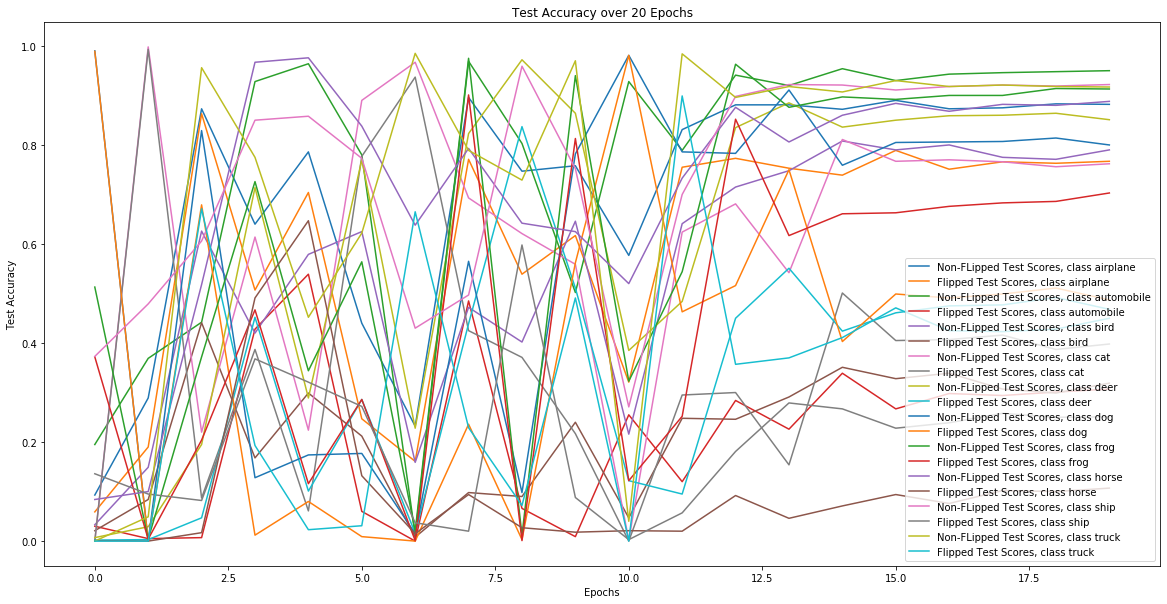

In [35]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 20
test_scores = []
flipped_test_scores = []
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate_per_class(model, test_dl)
    flipped_test_loss, flipped_test_acc = evaluate_per_class(model, flipped_test_dl)
    test_scores.append(test_acc)
    flipped_test_scores.append(flipped_test_acc)
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}')
test_scores = np.array(test_scores)
flipped_test_scores = np.array(flipped_test_scores)
fig = plt.figure(figsize = (20, 10))
for i, label in enumerate(labels):
    plt.plot(test_scores[:, i], label='Non-FLipped Test Scores, class ' +label)
    plt.plot(flipped_test_scores[:, i], label='Flipped Test Scores, class ' +label)
plt.title('Test Accuracy over 20 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('Performances_per_class_after_20_epochs.png')
plt.show(fig)

##### Test performances over classes, over epochs: 40 epochs

Useless to do more than 40 epochs, the training loss is 0 for epoch > 40. 

Starting Epoch 0


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 5.240 	 Train Acc: 0.155
	 [Batch 100 / 782] Train Loss: 3.733 	 Train Acc: 0.165
	 [Batch 150 / 782] Train Loss: 3.197 	 Train Acc: 0.182
	 [Batch 200 / 782] Train Loss: 2.909 	 Train Acc: 0.197
	 [Batch 250 / 782] Train Loss: 2.710 	 Train Acc: 0.215
	 [Batch 300 / 782] Train Loss: 2.574 	 Train Acc: 0.230
	 [Batch 350 / 782] Train Loss: 2.473 	 Train Acc: 0.241
	 [Batch 400 / 782] Train Loss: 2.382 	 Train Acc: 0.257
	 [Batch 450 / 782] Train Loss: 2.307 	 Train Acc: 0.269
	 [Batch 500 / 782] Train Loss: 2.244 	 Train Acc: 0.280
	 [Batch 550 / 782] Train Loss: 2.188 	 Train Acc: 0.292
	 [Batch 600 / 782] Train Loss: 2.138 	 Train Acc: 0.302
	 [Batch 650 / 782] Train Loss: 2.093 	 Train Acc: 0.312
	 [Batch 700 / 782] Train Loss: 2.052 	 Train Acc: 0.321
	 [Batch 750 / 782] Train Loss: 2.010 	 Train Acc: 0.332
Epoch 0:	 Train Loss: 1.986 	 Train Acc: 0.339
Starting Epoch 1


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 1.457 	 Train Acc: 0.486
	 [Batch 100 / 782] Train Loss: 1.414 	 Train Acc: 0.493
	 [Batch 150 / 782] Train Loss: 1.387 	 Train Acc: 0.502
	 [Batch 200 / 782] Train Loss: 1.366 	 Train Acc: 0.507
	 [Batch 250 / 782] Train Loss: 1.356 	 Train Acc: 0.509
	 [Batch 300 / 782] Train Loss: 1.342 	 Train Acc: 0.513
	 [Batch 350 / 782] Train Loss: 1.334 	 Train Acc: 0.515
	 [Batch 400 / 782] Train Loss: 1.318 	 Train Acc: 0.523
	 [Batch 450 / 782] Train Loss: 1.300 	 Train Acc: 0.529
	 [Batch 500 / 782] Train Loss: 1.286 	 Train Acc: 0.535
	 [Batch 550 / 782] Train Loss: 1.273 	 Train Acc: 0.541
	 [Batch 600 / 782] Train Loss: 1.258 	 Train Acc: 0.547
	 [Batch 650 / 782] Train Loss: 1.247 	 Train Acc: 0.552
	 [Batch 700 / 782] Train Loss: 1.236 	 Train Acc: 0.557
	 [Batch 750 / 782] Train Loss: 1.224 	 Train Acc: 0.562
Epoch 1:	 Train Loss: 1.219 	 Train Acc: 0.564
Starting Epoch 2


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.983 	 Train Acc: 0.653
	 [Batch 100 / 782] Train Loss: 0.979 	 Train Acc: 0.646
	 [Batch 150 / 782] Train Loss: 0.979 	 Train Acc: 0.648
	 [Batch 200 / 782] Train Loss: 0.983 	 Train Acc: 0.649
	 [Batch 250 / 782] Train Loss: 0.982 	 Train Acc: 0.651
	 [Batch 300 / 782] Train Loss: 0.978 	 Train Acc: 0.653
	 [Batch 350 / 782] Train Loss: 0.973 	 Train Acc: 0.656
	 [Batch 400 / 782] Train Loss: 0.964 	 Train Acc: 0.660
	 [Batch 450 / 782] Train Loss: 0.956 	 Train Acc: 0.662
	 [Batch 500 / 782] Train Loss: 0.951 	 Train Acc: 0.665
	 [Batch 550 / 782] Train Loss: 0.944 	 Train Acc: 0.667
	 [Batch 600 / 782] Train Loss: 0.940 	 Train Acc: 0.669
	 [Batch 650 / 782] Train Loss: 0.934 	 Train Acc: 0.672
	 [Batch 700 / 782] Train Loss: 0.931 	 Train Acc: 0.673
	 [Batch 750 / 782] Train Loss: 0.928 	 Train Acc: 0.674
Epoch 2:	 Train Loss: 0.924 	 Train Acc: 0.675
Starting Epoch 3


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.749 	 Train Acc: 0.731
	 [Batch 100 / 782] Train Loss: 0.746 	 Train Acc: 0.738
	 [Batch 150 / 782] Train Loss: 0.739 	 Train Acc: 0.740
	 [Batch 200 / 782] Train Loss: 0.768 	 Train Acc: 0.735
	 [Batch 250 / 782] Train Loss: 0.764 	 Train Acc: 0.735
	 [Batch 300 / 782] Train Loss: 0.754 	 Train Acc: 0.739
	 [Batch 350 / 782] Train Loss: 0.757 	 Train Acc: 0.739
	 [Batch 400 / 782] Train Loss: 0.755 	 Train Acc: 0.740
	 [Batch 450 / 782] Train Loss: 0.755 	 Train Acc: 0.740
	 [Batch 500 / 782] Train Loss: 0.757 	 Train Acc: 0.740
	 [Batch 550 / 782] Train Loss: 0.749 	 Train Acc: 0.743
	 [Batch 600 / 782] Train Loss: 0.746 	 Train Acc: 0.744
	 [Batch 650 / 782] Train Loss: 0.743 	 Train Acc: 0.745
	 [Batch 700 / 782] Train Loss: 0.743 	 Train Acc: 0.744
	 [Batch 750 / 782] Train Loss: 0.741 	 Train Acc: 0.745
Epoch 3:	 Train Loss: 0.739 	 Train Acc: 0.745
Starting Epoch 4


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.636 	 Train Acc: 0.778
	 [Batch 100 / 782] Train Loss: 0.629 	 Train Acc: 0.778
	 [Batch 150 / 782] Train Loss: 0.621 	 Train Acc: 0.781
	 [Batch 200 / 782] Train Loss: 0.612 	 Train Acc: 0.784
	 [Batch 250 / 782] Train Loss: 0.607 	 Train Acc: 0.787
	 [Batch 300 / 782] Train Loss: 0.610 	 Train Acc: 0.787
	 [Batch 350 / 782] Train Loss: 0.611 	 Train Acc: 0.786
	 [Batch 400 / 782] Train Loss: 0.616 	 Train Acc: 0.785
	 [Batch 450 / 782] Train Loss: 0.616 	 Train Acc: 0.787
	 [Batch 500 / 782] Train Loss: 0.621 	 Train Acc: 0.785
	 [Batch 550 / 782] Train Loss: 0.619 	 Train Acc: 0.786
	 [Batch 600 / 782] Train Loss: 0.622 	 Train Acc: 0.785
	 [Batch 650 / 782] Train Loss: 0.621 	 Train Acc: 0.786
	 [Batch 700 / 782] Train Loss: 0.622 	 Train Acc: 0.786
	 [Batch 750 / 782] Train Loss: 0.617 	 Train Acc: 0.788
Epoch 4:	 Train Loss: 0.617 	 Train Acc: 0.788
Starting Epoch 5


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.484 	 Train Acc: 0.841
	 [Batch 100 / 782] Train Loss: 0.485 	 Train Acc: 0.835
	 [Batch 150 / 782] Train Loss: 0.496 	 Train Acc: 0.830
	 [Batch 200 / 782] Train Loss: 0.505 	 Train Acc: 0.828
	 [Batch 250 / 782] Train Loss: 0.509 	 Train Acc: 0.826
	 [Batch 300 / 782] Train Loss: 0.511 	 Train Acc: 0.826
	 [Batch 350 / 782] Train Loss: 0.511 	 Train Acc: 0.826
	 [Batch 400 / 782] Train Loss: 0.508 	 Train Acc: 0.827
	 [Batch 450 / 782] Train Loss: 0.510 	 Train Acc: 0.826
	 [Batch 500 / 782] Train Loss: 0.510 	 Train Acc: 0.827
	 [Batch 550 / 782] Train Loss: 0.509 	 Train Acc: 0.827
	 [Batch 600 / 782] Train Loss: 0.510 	 Train Acc: 0.826
	 [Batch 650 / 782] Train Loss: 0.512 	 Train Acc: 0.825
	 [Batch 700 / 782] Train Loss: 0.514 	 Train Acc: 0.825
	 [Batch 750 / 782] Train Loss: 0.514 	 Train Acc: 0.825
Epoch 5:	 Train Loss: 0.513 	 Train Acc: 0.825
Starting Epoch 6


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.461 	 Train Acc: 0.842
	 [Batch 100 / 782] Train Loss: 0.441 	 Train Acc: 0.848
	 [Batch 150 / 782] Train Loss: 0.424 	 Train Acc: 0.854
	 [Batch 200 / 782] Train Loss: 0.418 	 Train Acc: 0.857
	 [Batch 250 / 782] Train Loss: 0.414 	 Train Acc: 0.858
	 [Batch 300 / 782] Train Loss: 0.421 	 Train Acc: 0.856
	 [Batch 350 / 782] Train Loss: 0.419 	 Train Acc: 0.857
	 [Batch 400 / 782] Train Loss: 0.414 	 Train Acc: 0.858
	 [Batch 450 / 782] Train Loss: 0.419 	 Train Acc: 0.856
	 [Batch 500 / 782] Train Loss: 0.420 	 Train Acc: 0.856
	 [Batch 550 / 782] Train Loss: 0.424 	 Train Acc: 0.854
	 [Batch 600 / 782] Train Loss: 0.425 	 Train Acc: 0.854
	 [Batch 650 / 782] Train Loss: 0.427 	 Train Acc: 0.854
	 [Batch 700 / 782] Train Loss: 0.426 	 Train Acc: 0.854
	 [Batch 750 / 782] Train Loss: 0.425 	 Train Acc: 0.854
Epoch 6:	 Train Loss: 0.426 	 Train Acc: 0.853
Starting Epoch 7


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.334 	 Train Acc: 0.879
	 [Batch 100 / 782] Train Loss: 0.343 	 Train Acc: 0.881
	 [Batch 150 / 782] Train Loss: 0.348 	 Train Acc: 0.879
	 [Batch 200 / 782] Train Loss: 0.343 	 Train Acc: 0.881
	 [Batch 250 / 782] Train Loss: 0.348 	 Train Acc: 0.879
	 [Batch 300 / 782] Train Loss: 0.349 	 Train Acc: 0.878
	 [Batch 350 / 782] Train Loss: 0.356 	 Train Acc: 0.876
	 [Batch 400 / 782] Train Loss: 0.357 	 Train Acc: 0.876
	 [Batch 450 / 782] Train Loss: 0.359 	 Train Acc: 0.875
	 [Batch 500 / 782] Train Loss: 0.361 	 Train Acc: 0.874
	 [Batch 550 / 782] Train Loss: 0.365 	 Train Acc: 0.874
	 [Batch 600 / 782] Train Loss: 0.361 	 Train Acc: 0.875
	 [Batch 650 / 782] Train Loss: 0.363 	 Train Acc: 0.875
	 [Batch 700 / 782] Train Loss: 0.363 	 Train Acc: 0.875
	 [Batch 750 / 782] Train Loss: 0.366 	 Train Acc: 0.874
Epoch 7:	 Train Loss: 0.367 	 Train Acc: 0.874
Starting Epoch 8


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.233 	 Train Acc: 0.923
	 [Batch 100 / 782] Train Loss: 0.256 	 Train Acc: 0.917
	 [Batch 150 / 782] Train Loss: 0.262 	 Train Acc: 0.913
	 [Batch 200 / 782] Train Loss: 0.258 	 Train Acc: 0.913
	 [Batch 250 / 782] Train Loss: 0.257 	 Train Acc: 0.912
	 [Batch 300 / 782] Train Loss: 0.267 	 Train Acc: 0.908
	 [Batch 350 / 782] Train Loss: 0.268 	 Train Acc: 0.907
	 [Batch 400 / 782] Train Loss: 0.270 	 Train Acc: 0.907
	 [Batch 450 / 782] Train Loss: 0.271 	 Train Acc: 0.907
	 [Batch 500 / 782] Train Loss: 0.270 	 Train Acc: 0.907
	 [Batch 550 / 782] Train Loss: 0.271 	 Train Acc: 0.907
	 [Batch 600 / 782] Train Loss: 0.271 	 Train Acc: 0.907
	 [Batch 650 / 782] Train Loss: 0.271 	 Train Acc: 0.907
	 [Batch 700 / 782] Train Loss: 0.274 	 Train Acc: 0.907
	 [Batch 750 / 782] Train Loss: 0.276 	 Train Acc: 0.906
Epoch 8:	 Train Loss: 0.279 	 Train Acc: 0.905
Starting Epoch 9


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.198 	 Train Acc: 0.938
	 [Batch 100 / 782] Train Loss: 0.175 	 Train Acc: 0.943
	 [Batch 150 / 782] Train Loss: 0.185 	 Train Acc: 0.938
	 [Batch 200 / 782] Train Loss: 0.193 	 Train Acc: 0.936
	 [Batch 250 / 782] Train Loss: 0.195 	 Train Acc: 0.934
	 [Batch 300 / 782] Train Loss: 0.201 	 Train Acc: 0.932
	 [Batch 350 / 782] Train Loss: 0.211 	 Train Acc: 0.929
	 [Batch 400 / 782] Train Loss: 0.209 	 Train Acc: 0.930
	 [Batch 450 / 782] Train Loss: 0.214 	 Train Acc: 0.929
	 [Batch 500 / 782] Train Loss: 0.217 	 Train Acc: 0.927
	 [Batch 550 / 782] Train Loss: 0.218 	 Train Acc: 0.927
	 [Batch 600 / 782] Train Loss: 0.217 	 Train Acc: 0.927
	 [Batch 650 / 782] Train Loss: 0.217 	 Train Acc: 0.927
	 [Batch 700 / 782] Train Loss: 0.216 	 Train Acc: 0.928
	 [Batch 750 / 782] Train Loss: 0.219 	 Train Acc: 0.926
Epoch 9:	 Train Loss: 0.219 	 Train Acc: 0.926
Starting Epoch 10


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.106 	 Train Acc: 0.967
	 [Batch 100 / 782] Train Loss: 0.113 	 Train Acc: 0.964
	 [Batch 150 / 782] Train Loss: 0.130 	 Train Acc: 0.960
	 [Batch 200 / 782] Train Loss: 0.127 	 Train Acc: 0.959
	 [Batch 250 / 782] Train Loss: 0.125 	 Train Acc: 0.959
	 [Batch 300 / 782] Train Loss: 0.125 	 Train Acc: 0.959
	 [Batch 350 / 782] Train Loss: 0.126 	 Train Acc: 0.959
	 [Batch 400 / 782] Train Loss: 0.131 	 Train Acc: 0.957
	 [Batch 450 / 782] Train Loss: 0.140 	 Train Acc: 0.955
	 [Batch 500 / 782] Train Loss: 0.141 	 Train Acc: 0.954
	 [Batch 550 / 782] Train Loss: 0.141 	 Train Acc: 0.954
	 [Batch 600 / 782] Train Loss: 0.143 	 Train Acc: 0.953
	 [Batch 650 / 782] Train Loss: 0.143 	 Train Acc: 0.953
	 [Batch 700 / 782] Train Loss: 0.143 	 Train Acc: 0.953
	 [Batch 750 / 782] Train Loss: 0.150 	 Train Acc: 0.951
Epoch 10:	 Train Loss: 0.150 	 Train Acc: 0.951
Starting Epoch 11


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.073 	 Train Acc: 0.977
	 [Batch 100 / 782] Train Loss: 0.079 	 Train Acc: 0.973
	 [Batch 150 / 782] Train Loss: 0.071 	 Train Acc: 0.977
	 [Batch 200 / 782] Train Loss: 0.075 	 Train Acc: 0.976
	 [Batch 250 / 782] Train Loss: 0.077 	 Train Acc: 0.975
	 [Batch 300 / 782] Train Loss: 0.078 	 Train Acc: 0.975
	 [Batch 350 / 782] Train Loss: 0.078 	 Train Acc: 0.975
	 [Batch 400 / 782] Train Loss: 0.086 	 Train Acc: 0.973
	 [Batch 450 / 782] Train Loss: 0.087 	 Train Acc: 0.972
	 [Batch 500 / 782] Train Loss: 0.086 	 Train Acc: 0.973
	 [Batch 550 / 782] Train Loss: 0.090 	 Train Acc: 0.971
	 [Batch 600 / 782] Train Loss: 0.089 	 Train Acc: 0.971
	 [Batch 650 / 782] Train Loss: 0.090 	 Train Acc: 0.971
	 [Batch 700 / 782] Train Loss: 0.091 	 Train Acc: 0.970
	 [Batch 750 / 782] Train Loss: 0.094 	 Train Acc: 0.969
Epoch 11:	 Train Loss: 0.094 	 Train Acc: 0.969
Starting Epoch 12


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.044 	 Train Acc: 0.987
	 [Batch 100 / 782] Train Loss: 0.043 	 Train Acc: 0.988
	 [Batch 150 / 782] Train Loss: 0.057 	 Train Acc: 0.984
	 [Batch 200 / 782] Train Loss: 0.052 	 Train Acc: 0.986
	 [Batch 250 / 782] Train Loss: 0.049 	 Train Acc: 0.987
	 [Batch 300 / 782] Train Loss: 0.049 	 Train Acc: 0.986
	 [Batch 350 / 782] Train Loss: 0.049 	 Train Acc: 0.986
	 [Batch 400 / 782] Train Loss: 0.051 	 Train Acc: 0.985
	 [Batch 450 / 782] Train Loss: 0.052 	 Train Acc: 0.984
	 [Batch 500 / 782] Train Loss: 0.051 	 Train Acc: 0.985
	 [Batch 550 / 782] Train Loss: 0.050 	 Train Acc: 0.985
	 [Batch 600 / 782] Train Loss: 0.048 	 Train Acc: 0.986
	 [Batch 650 / 782] Train Loss: 0.048 	 Train Acc: 0.986
	 [Batch 700 / 782] Train Loss: 0.049 	 Train Acc: 0.986
	 [Batch 750 / 782] Train Loss: 0.049 	 Train Acc: 0.986
Epoch 12:	 Train Loss: 0.049 	 Train Acc: 0.985
Starting Epoch 13


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.022 	 Train Acc: 0.994
	 [Batch 100 / 782] Train Loss: 0.018 	 Train Acc: 0.996
	 [Batch 150 / 782] Train Loss: 0.018 	 Train Acc: 0.997
	 [Batch 200 / 782] Train Loss: 0.017 	 Train Acc: 0.997
	 [Batch 250 / 782] Train Loss: 0.017 	 Train Acc: 0.998
	 [Batch 300 / 782] Train Loss: 0.016 	 Train Acc: 0.998
	 [Batch 350 / 782] Train Loss: 0.016 	 Train Acc: 0.998
	 [Batch 400 / 782] Train Loss: 0.016 	 Train Acc: 0.997
	 [Batch 450 / 782] Train Loss: 0.016 	 Train Acc: 0.997
	 [Batch 500 / 782] Train Loss: 0.017 	 Train Acc: 0.997
	 [Batch 550 / 782] Train Loss: 0.017 	 Train Acc: 0.997
	 [Batch 600 / 782] Train Loss: 0.017 	 Train Acc: 0.997
	 [Batch 650 / 782] Train Loss: 0.017 	 Train Acc: 0.997
	 [Batch 700 / 782] Train Loss: 0.016 	 Train Acc: 0.997
	 [Batch 750 / 782] Train Loss: 0.017 	 Train Acc: 0.997
Epoch 13:	 Train Loss: 0.016 	 Train Acc: 0.997
Starting Epoch 14


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.018 	 Train Acc: 0.995
	 [Batch 100 / 782] Train Loss: 0.013 	 Train Acc: 0.998
	 [Batch 150 / 782] Train Loss: 0.011 	 Train Acc: 0.998
	 [Batch 200 / 782] Train Loss: 0.011 	 Train Acc: 0.998
	 [Batch 250 / 782] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 300 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 350 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 400 / 782] Train Loss: 0.009 	 Train Acc: 0.999
	 [Batch 450 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 500 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 550 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 600 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 650 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 700 / 782] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 750 / 782] Train Loss: 0.007 	 Train Acc: 0.999
Epoch 14:	 Train Loss: 0.007 	 Train Acc: 0.999
Starting Epoch 15


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 15:	 Train Loss: 0.003 	 Train Acc: 1.000
Starting Epoch 16


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 16:	 Train Loss: 0.002 	 Train Acc: 1.000
Starting Epoch 17


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.002 	 Train Acc: 1.000
Starting Epoch 18


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 19


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 20


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 20:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 21


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 21:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 22


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 22:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 23


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 23:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 24


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 24:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 25


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 25:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 26


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 26:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 27


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 27:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 28


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.001 	 Train Acc: 1.000
Epoch 28:	 Train Loss: 0.001 	 Train Acc: 1.000
Starting Epoch 29


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 29:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 30


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 30:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 31


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 31:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 32


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 32:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 33


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 33:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 34


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 34:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 35


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 35:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 36


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 36:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 37


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 37:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 38


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 782] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 782] Train Loss: 0.000 	 Train Acc: 1.000
Epoch 38:	 Train Loss: 0.000 	 Train Acc: 1.000
Starting Epoch 39


  0%|          | 0/782 [00:00<?, ?it/s]

	 [Batch 50 / 782] Train Loss: 0.068 	 Train Acc: 0.985
	 [Batch 100 / 782] Train Loss: 0.035 	 Train Acc: 0.993
	 [Batch 150 / 782] Train Loss: 0.024 	 Train Acc: 0.995
	 [Batch 200 / 782] Train Loss: 0.019 	 Train Acc: 0.996
	 [Batch 250 / 782] Train Loss: 0.015 	 Train Acc: 0.997
	 [Batch 300 / 782] Train Loss: 0.013 	 Train Acc: 0.997
	 [Batch 350 / 782] Train Loss: 0.011 	 Train Acc: 0.998
	 [Batch 400 / 782] Train Loss: 0.010 	 Train Acc: 0.998
	 [Batch 450 / 782] Train Loss: 0.009 	 Train Acc: 0.998
	 [Batch 500 / 782] Train Loss: 0.008 	 Train Acc: 0.998
	 [Batch 550 / 782] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 600 / 782] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 650 / 782] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 700 / 782] Train Loss: 0.006 	 Train Acc: 0.999
	 [Batch 750 / 782] Train Loss: 0.006 	 Train Acc: 0.999
Epoch 39:	 Train Loss: 0.006 	 Train Acc: 0.999


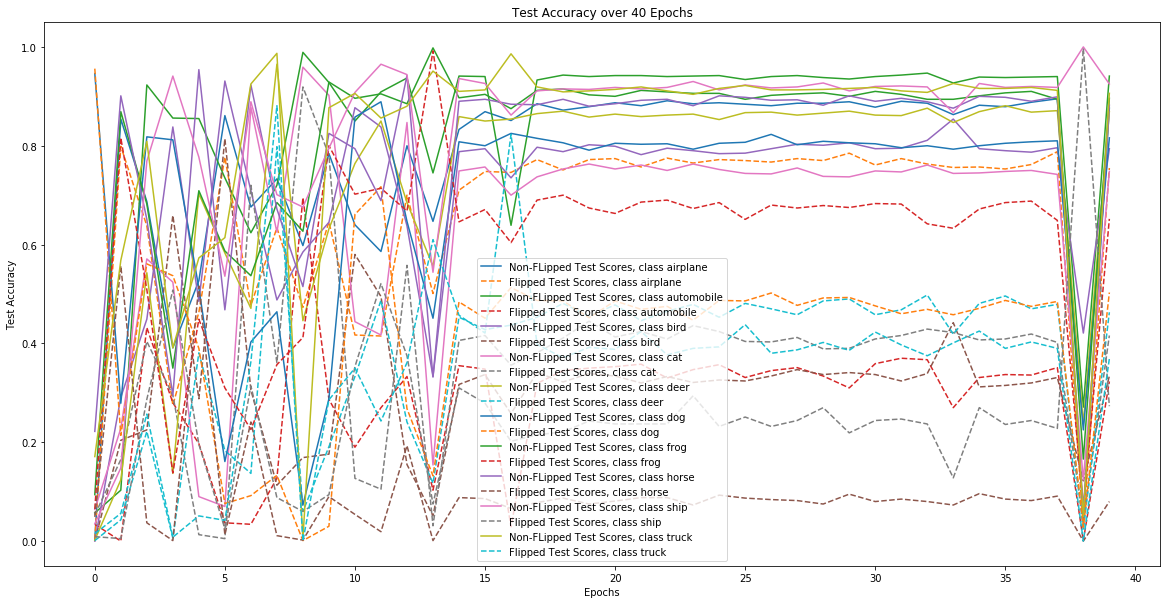

In [9]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 40
test_scores = []
flipped_test_scores = []
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate_per_class(model, test_dl)
    flipped_test_loss, flipped_test_acc = evaluate_per_class(model, flipped_test_dl)
    test_scores.append(test_acc)
    flipped_test_scores.append(flipped_test_acc)
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}')
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
test_scores = np.array(test_scores)
flipped_test_scores = np.array(flipped_test_scores)
fig = plt.figure(figsize = (20, 10))
for i, label in enumerate(labels):
    plt.plot(test_scores[:, i], label='Non-FLipped Test Scores, class ' +label)
    plt.plot(flipped_test_scores[:, i], label='Flipped Test Scores, class ' +label, linestyle='--')
plt.title('Test Accuracy over 40 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('Performances_per_class_after_40_epochs.png')
plt.show(fig)

##### Modify the training procedure in order to allow our model to be robust to such cases

The first technique is to perform data augmentation in our dataset, in order also to train our model in the case when such situation occurs.

In [5]:
X_tr_flipped = torch.flip(X_tr, [2, 3])
X_training = torch.cat((X_tr, X_tr_flipped), 0)
Y_training = torch.cat((Y_tr, Y_tr), 0)
train_dl = make_loader(TensorDataset(X_training, Y_training), batch_size=64)

Starting Epoch 0


  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 6.649 	 Train Acc: 0.133
	 [Batch 100 / 1563] Train Loss: 4.447 	 Train Acc: 0.161
	 [Batch 150 / 1563] Train Loss: 3.681 	 Train Acc: 0.184
	 [Batch 200 / 1563] Train Loss: 3.274 	 Train Acc: 0.200
	 [Batch 250 / 1563] Train Loss: 3.018 	 Train Acc: 0.214
	 [Batch 300 / 1563] Train Loss: 2.830 	 Train Acc: 0.227
	 [Batch 350 / 1563] Train Loss: 2.687 	 Train Acc: 0.239
	 [Batch 400 / 1563] Train Loss: 2.572 	 Train Acc: 0.253
	 [Batch 450 / 1563] Train Loss: 2.476 	 Train Acc: 0.266
	 [Batch 500 / 1563] Train Loss: 2.398 	 Train Acc: 0.277
	 [Batch 550 / 1563] Train Loss: 2.331 	 Train Acc: 0.287
	 [Batch 600 / 1563] Train Loss: 2.270 	 Train Acc: 0.299
	 [Batch 650 / 1563] Train Loss: 2.219 	 Train Acc: 0.306
	 [Batch 700 / 1563] Train Loss: 2.171 	 Train Acc: 0.315
	 [Batch 750 / 1563] Train Loss: 2.127 	 Train Acc: 0.324
	 [Batch 800 / 1563] Train Loss: 2.088 	 Train Acc: 0.332
	 [Batch 850 / 1563] Train Loss: 2.051 	 Train Acc: 0.340
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 1.197 	 Train Acc: 0.570
	 [Batch 100 / 1563] Train Loss: 1.181 	 Train Acc: 0.570
	 [Batch 150 / 1563] Train Loss: 1.163 	 Train Acc: 0.579
	 [Batch 200 / 1563] Train Loss: 1.149 	 Train Acc: 0.586
	 [Batch 250 / 1563] Train Loss: 1.139 	 Train Acc: 0.590
	 [Batch 300 / 1563] Train Loss: 1.139 	 Train Acc: 0.589
	 [Batch 350 / 1563] Train Loss: 1.138 	 Train Acc: 0.590
	 [Batch 400 / 1563] Train Loss: 1.133 	 Train Acc: 0.592
	 [Batch 450 / 1563] Train Loss: 1.131 	 Train Acc: 0.593
	 [Batch 500 / 1563] Train Loss: 1.131 	 Train Acc: 0.593
	 [Batch 550 / 1563] Train Loss: 1.125 	 Train Acc: 0.595
	 [Batch 600 / 1563] Train Loss: 1.121 	 Train Acc: 0.597
	 [Batch 650 / 1563] Train Loss: 1.116 	 Train Acc: 0.599
	 [Batch 700 / 1563] Train Loss: 1.111 	 Train Acc: 0.602
	 [Batch 750 / 1563] Train Loss: 1.108 	 Train Acc: 0.603
	 [Batch 800 / 1563] Train Loss: 1.102 	 Train Acc: 0.605
	 [Batch 850 / 1563] Train Loss: 1.099 	 Train Acc: 0.607
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.832 	 Train Acc: 0.701
	 [Batch 100 / 1563] Train Loss: 0.826 	 Train Acc: 0.699
	 [Batch 150 / 1563] Train Loss: 0.831 	 Train Acc: 0.704
	 [Batch 200 / 1563] Train Loss: 0.828 	 Train Acc: 0.705
	 [Batch 250 / 1563] Train Loss: 0.833 	 Train Acc: 0.702
	 [Batch 300 / 1563] Train Loss: 0.835 	 Train Acc: 0.701
	 [Batch 350 / 1563] Train Loss: 0.842 	 Train Acc: 0.699
	 [Batch 400 / 1563] Train Loss: 0.843 	 Train Acc: 0.699
	 [Batch 450 / 1563] Train Loss: 0.843 	 Train Acc: 0.698
	 [Batch 500 / 1563] Train Loss: 0.842 	 Train Acc: 0.700
	 [Batch 550 / 1563] Train Loss: 0.838 	 Train Acc: 0.702
	 [Batch 600 / 1563] Train Loss: 0.835 	 Train Acc: 0.703
	 [Batch 650 / 1563] Train Loss: 0.834 	 Train Acc: 0.704
	 [Batch 700 / 1563] Train Loss: 0.835 	 Train Acc: 0.703
	 [Batch 750 / 1563] Train Loss: 0.834 	 Train Acc: 0.704
	 [Batch 800 / 1563] Train Loss: 0.832 	 Train Acc: 0.705
	 [Batch 850 / 1563] Train Loss: 0.830 	 Train Acc: 0.706
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.650 	 Train Acc: 0.782
	 [Batch 100 / 1563] Train Loss: 0.654 	 Train Acc: 0.776
	 [Batch 150 / 1563] Train Loss: 0.672 	 Train Acc: 0.766
	 [Batch 200 / 1563] Train Loss: 0.679 	 Train Acc: 0.762
	 [Batch 250 / 1563] Train Loss: 0.683 	 Train Acc: 0.761
	 [Batch 300 / 1563] Train Loss: 0.687 	 Train Acc: 0.760
	 [Batch 350 / 1563] Train Loss: 0.685 	 Train Acc: 0.760
	 [Batch 400 / 1563] Train Loss: 0.684 	 Train Acc: 0.759
	 [Batch 450 / 1563] Train Loss: 0.682 	 Train Acc: 0.760
	 [Batch 500 / 1563] Train Loss: 0.678 	 Train Acc: 0.761
	 [Batch 550 / 1563] Train Loss: 0.681 	 Train Acc: 0.760
	 [Batch 600 / 1563] Train Loss: 0.679 	 Train Acc: 0.760
	 [Batch 650 / 1563] Train Loss: 0.681 	 Train Acc: 0.760
	 [Batch 700 / 1563] Train Loss: 0.680 	 Train Acc: 0.760
	 [Batch 750 / 1563] Train Loss: 0.682 	 Train Acc: 0.760
	 [Batch 800 / 1563] Train Loss: 0.680 	 Train Acc: 0.761
	 [Batch 850 / 1563] Train Loss: 0.679 	 Train Acc: 0.761
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.564 	 Train Acc: 0.808
	 [Batch 100 / 1563] Train Loss: 0.561 	 Train Acc: 0.805
	 [Batch 150 / 1563] Train Loss: 0.556 	 Train Acc: 0.805
	 [Batch 200 / 1563] Train Loss: 0.557 	 Train Acc: 0.807
	 [Batch 250 / 1563] Train Loss: 0.557 	 Train Acc: 0.808
	 [Batch 300 / 1563] Train Loss: 0.564 	 Train Acc: 0.804
	 [Batch 350 / 1563] Train Loss: 0.561 	 Train Acc: 0.805
	 [Batch 400 / 1563] Train Loss: 0.563 	 Train Acc: 0.803
	 [Batch 450 / 1563] Train Loss: 0.563 	 Train Acc: 0.804
	 [Batch 500 / 1563] Train Loss: 0.564 	 Train Acc: 0.804
	 [Batch 550 / 1563] Train Loss: 0.563 	 Train Acc: 0.804
	 [Batch 600 / 1563] Train Loss: 0.563 	 Train Acc: 0.805
	 [Batch 650 / 1563] Train Loss: 0.562 	 Train Acc: 0.804
	 [Batch 700 / 1563] Train Loss: 0.563 	 Train Acc: 0.804
	 [Batch 750 / 1563] Train Loss: 0.563 	 Train Acc: 0.804
	 [Batch 800 / 1563] Train Loss: 0.563 	 Train Acc: 0.804
	 [Batch 850 / 1563] Train Loss: 0.563 	 Train Acc: 0.804
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.437 	 Train Acc: 0.849
	 [Batch 100 / 1563] Train Loss: 0.461 	 Train Acc: 0.836
	 [Batch 150 / 1563] Train Loss: 0.459 	 Train Acc: 0.840
	 [Batch 200 / 1563] Train Loss: 0.460 	 Train Acc: 0.839
	 [Batch 250 / 1563] Train Loss: 0.470 	 Train Acc: 0.837
	 [Batch 300 / 1563] Train Loss: 0.466 	 Train Acc: 0.839
	 [Batch 350 / 1563] Train Loss: 0.469 	 Train Acc: 0.838
	 [Batch 400 / 1563] Train Loss: 0.470 	 Train Acc: 0.836
	 [Batch 450 / 1563] Train Loss: 0.473 	 Train Acc: 0.835
	 [Batch 500 / 1563] Train Loss: 0.474 	 Train Acc: 0.835
	 [Batch 550 / 1563] Train Loss: 0.476 	 Train Acc: 0.834
	 [Batch 600 / 1563] Train Loss: 0.476 	 Train Acc: 0.834
	 [Batch 650 / 1563] Train Loss: 0.476 	 Train Acc: 0.834
	 [Batch 700 / 1563] Train Loss: 0.475 	 Train Acc: 0.834
	 [Batch 750 / 1563] Train Loss: 0.474 	 Train Acc: 0.834
	 [Batch 800 / 1563] Train Loss: 0.475 	 Train Acc: 0.834
	 [Batch 850 / 1563] Train Loss: 0.474 	 Train Acc: 0.834
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.339 	 Train Acc: 0.882
	 [Batch 100 / 1563] Train Loss: 0.348 	 Train Acc: 0.880
	 [Batch 150 / 1563] Train Loss: 0.347 	 Train Acc: 0.879
	 [Batch 200 / 1563] Train Loss: 0.356 	 Train Acc: 0.875
	 [Batch 250 / 1563] Train Loss: 0.358 	 Train Acc: 0.875
	 [Batch 300 / 1563] Train Loss: 0.363 	 Train Acc: 0.873
	 [Batch 350 / 1563] Train Loss: 0.368 	 Train Acc: 0.871
	 [Batch 400 / 1563] Train Loss: 0.373 	 Train Acc: 0.869
	 [Batch 450 / 1563] Train Loss: 0.378 	 Train Acc: 0.868
	 [Batch 500 / 1563] Train Loss: 0.380 	 Train Acc: 0.867
	 [Batch 550 / 1563] Train Loss: 0.382 	 Train Acc: 0.867
	 [Batch 600 / 1563] Train Loss: 0.383 	 Train Acc: 0.866
	 [Batch 650 / 1563] Train Loss: 0.384 	 Train Acc: 0.866
	 [Batch 700 / 1563] Train Loss: 0.384 	 Train Acc: 0.866
	 [Batch 750 / 1563] Train Loss: 0.385 	 Train Acc: 0.865
	 [Batch 800 / 1563] Train Loss: 0.385 	 Train Acc: 0.865
	 [Batch 850 / 1563] Train Loss: 0.386 	 Train Acc: 0.865
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.276 	 Train Acc: 0.902
	 [Batch 100 / 1563] Train Loss: 0.280 	 Train Acc: 0.901
	 [Batch 150 / 1563] Train Loss: 0.305 	 Train Acc: 0.896
	 [Batch 200 / 1563] Train Loss: 0.301 	 Train Acc: 0.898
	 [Batch 250 / 1563] Train Loss: 0.295 	 Train Acc: 0.899
	 [Batch 300 / 1563] Train Loss: 0.295 	 Train Acc: 0.898
	 [Batch 350 / 1563] Train Loss: 0.294 	 Train Acc: 0.899
	 [Batch 400 / 1563] Train Loss: 0.296 	 Train Acc: 0.898
	 [Batch 450 / 1563] Train Loss: 0.294 	 Train Acc: 0.898
	 [Batch 500 / 1563] Train Loss: 0.300 	 Train Acc: 0.896
	 [Batch 550 / 1563] Train Loss: 0.304 	 Train Acc: 0.895
	 [Batch 600 / 1563] Train Loss: 0.306 	 Train Acc: 0.895
	 [Batch 650 / 1563] Train Loss: 0.308 	 Train Acc: 0.894
	 [Batch 700 / 1563] Train Loss: 0.310 	 Train Acc: 0.893
	 [Batch 750 / 1563] Train Loss: 0.310 	 Train Acc: 0.893
	 [Batch 800 / 1563] Train Loss: 0.310 	 Train Acc: 0.893
	 [Batch 850 / 1563] Train Loss: 0.310 	 Train Acc: 0.892
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.225 	 Train Acc: 0.918
	 [Batch 100 / 1563] Train Loss: 0.220 	 Train Acc: 0.921
	 [Batch 150 / 1563] Train Loss: 0.222 	 Train Acc: 0.920
	 [Batch 200 / 1563] Train Loss: 0.219 	 Train Acc: 0.923
	 [Batch 250 / 1563] Train Loss: 0.228 	 Train Acc: 0.920
	 [Batch 300 / 1563] Train Loss: 0.229 	 Train Acc: 0.919
	 [Batch 350 / 1563] Train Loss: 0.228 	 Train Acc: 0.920
	 [Batch 400 / 1563] Train Loss: 0.230 	 Train Acc: 0.919
	 [Batch 450 / 1563] Train Loss: 0.232 	 Train Acc: 0.919
	 [Batch 500 / 1563] Train Loss: 0.233 	 Train Acc: 0.918
	 [Batch 550 / 1563] Train Loss: 0.234 	 Train Acc: 0.917
	 [Batch 600 / 1563] Train Loss: 0.236 	 Train Acc: 0.916
	 [Batch 650 / 1563] Train Loss: 0.234 	 Train Acc: 0.917
	 [Batch 700 / 1563] Train Loss: 0.236 	 Train Acc: 0.917
	 [Batch 750 / 1563] Train Loss: 0.237 	 Train Acc: 0.916
	 [Batch 800 / 1563] Train Loss: 0.237 	 Train Acc: 0.916
	 [Batch 850 / 1563] Train Loss: 0.239 	 Train Acc: 0.916
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.140 	 Train Acc: 0.950
	 [Batch 100 / 1563] Train Loss: 0.133 	 Train Acc: 0.955
	 [Batch 150 / 1563] Train Loss: 0.138 	 Train Acc: 0.953
	 [Batch 200 / 1563] Train Loss: 0.139 	 Train Acc: 0.953
	 [Batch 250 / 1563] Train Loss: 0.138 	 Train Acc: 0.953
	 [Batch 300 / 1563] Train Loss: 0.145 	 Train Acc: 0.951
	 [Batch 350 / 1563] Train Loss: 0.149 	 Train Acc: 0.949
	 [Batch 400 / 1563] Train Loss: 0.149 	 Train Acc: 0.949
	 [Batch 450 / 1563] Train Loss: 0.152 	 Train Acc: 0.948
	 [Batch 500 / 1563] Train Loss: 0.159 	 Train Acc: 0.946
	 [Batch 550 / 1563] Train Loss: 0.161 	 Train Acc: 0.945
	 [Batch 600 / 1563] Train Loss: 0.163 	 Train Acc: 0.944
	 [Batch 650 / 1563] Train Loss: 0.165 	 Train Acc: 0.943
	 [Batch 700 / 1563] Train Loss: 0.170 	 Train Acc: 0.942
	 [Batch 750 / 1563] Train Loss: 0.170 	 Train Acc: 0.942
	 [Batch 800 / 1563] Train Loss: 0.170 	 Train Acc: 0.942
	 [Batch 850 / 1563] Train Loss: 0.171 	 Train Acc: 0.942
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.084 	 Train Acc: 0.976
	 [Batch 100 / 1563] Train Loss: 0.093 	 Train Acc: 0.973
	 [Batch 150 / 1563] Train Loss: 0.101 	 Train Acc: 0.970
	 [Batch 200 / 1563] Train Loss: 0.100 	 Train Acc: 0.969
	 [Batch 250 / 1563] Train Loss: 0.096 	 Train Acc: 0.970
	 [Batch 300 / 1563] Train Loss: 0.101 	 Train Acc: 0.967
	 [Batch 350 / 1563] Train Loss: 0.100 	 Train Acc: 0.967
	 [Batch 400 / 1563] Train Loss: 0.100 	 Train Acc: 0.967
	 [Batch 450 / 1563] Train Loss: 0.102 	 Train Acc: 0.966
	 [Batch 500 / 1563] Train Loss: 0.104 	 Train Acc: 0.965
	 [Batch 550 / 1563] Train Loss: 0.104 	 Train Acc: 0.965
	 [Batch 600 / 1563] Train Loss: 0.106 	 Train Acc: 0.964
	 [Batch 650 / 1563] Train Loss: 0.105 	 Train Acc: 0.965
	 [Batch 700 / 1563] Train Loss: 0.106 	 Train Acc: 0.965
	 [Batch 750 / 1563] Train Loss: 0.108 	 Train Acc: 0.964
	 [Batch 800 / 1563] Train Loss: 0.109 	 Train Acc: 0.964
	 [Batch 850 / 1563] Train Loss: 0.109 	 Train Acc: 0.963
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.090 	 Train Acc: 0.969
	 [Batch 100 / 1563] Train Loss: 0.078 	 Train Acc: 0.975
	 [Batch 150 / 1563] Train Loss: 0.073 	 Train Acc: 0.976
	 [Batch 200 / 1563] Train Loss: 0.071 	 Train Acc: 0.977
	 [Batch 250 / 1563] Train Loss: 0.071 	 Train Acc: 0.977
	 [Batch 300 / 1563] Train Loss: 0.072 	 Train Acc: 0.977
	 [Batch 350 / 1563] Train Loss: 0.073 	 Train Acc: 0.976
	 [Batch 400 / 1563] Train Loss: 0.072 	 Train Acc: 0.977
	 [Batch 450 / 1563] Train Loss: 0.072 	 Train Acc: 0.977
	 [Batch 500 / 1563] Train Loss: 0.072 	 Train Acc: 0.977
	 [Batch 550 / 1563] Train Loss: 0.071 	 Train Acc: 0.977
	 [Batch 600 / 1563] Train Loss: 0.072 	 Train Acc: 0.977
	 [Batch 650 / 1563] Train Loss: 0.075 	 Train Acc: 0.976
	 [Batch 700 / 1563] Train Loss: 0.076 	 Train Acc: 0.976
	 [Batch 750 / 1563] Train Loss: 0.075 	 Train Acc: 0.976
	 [Batch 800 / 1563] Train Loss: 0.075 	 Train Acc: 0.976
	 [Batch 850 / 1563] Train Loss: 0.076 	 Train Acc: 0.976
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.051 	 Train Acc: 0.986
	 [Batch 100 / 1563] Train Loss: 0.050 	 Train Acc: 0.985
	 [Batch 150 / 1563] Train Loss: 0.048 	 Train Acc: 0.985
	 [Batch 200 / 1563] Train Loss: 0.044 	 Train Acc: 0.987
	 [Batch 250 / 1563] Train Loss: 0.044 	 Train Acc: 0.987
	 [Batch 300 / 1563] Train Loss: 0.045 	 Train Acc: 0.986
	 [Batch 350 / 1563] Train Loss: 0.045 	 Train Acc: 0.986
	 [Batch 400 / 1563] Train Loss: 0.044 	 Train Acc: 0.986
	 [Batch 450 / 1563] Train Loss: 0.043 	 Train Acc: 0.987
	 [Batch 500 / 1563] Train Loss: 0.042 	 Train Acc: 0.988
	 [Batch 550 / 1563] Train Loss: 0.042 	 Train Acc: 0.987
	 [Batch 600 / 1563] Train Loss: 0.042 	 Train Acc: 0.987
	 [Batch 650 / 1563] Train Loss: 0.042 	 Train Acc: 0.987
	 [Batch 700 / 1563] Train Loss: 0.041 	 Train Acc: 0.988
	 [Batch 750 / 1563] Train Loss: 0.041 	 Train Acc: 0.988
	 [Batch 800 / 1563] Train Loss: 0.040 	 Train Acc: 0.988
	 [Batch 850 / 1563] Train Loss: 0.040 	 Train Acc: 0.988
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.030 	 Train Acc: 0.992
	 [Batch 100 / 1563] Train Loss: 0.024 	 Train Acc: 0.994
	 [Batch 150 / 1563] Train Loss: 0.023 	 Train Acc: 0.995
	 [Batch 200 / 1563] Train Loss: 0.022 	 Train Acc: 0.995
	 [Batch 250 / 1563] Train Loss: 0.022 	 Train Acc: 0.995
	 [Batch 300 / 1563] Train Loss: 0.022 	 Train Acc: 0.995
	 [Batch 350 / 1563] Train Loss: 0.022 	 Train Acc: 0.995
	 [Batch 400 / 1563] Train Loss: 0.021 	 Train Acc: 0.995
	 [Batch 450 / 1563] Train Loss: 0.021 	 Train Acc: 0.995
	 [Batch 500 / 1563] Train Loss: 0.021 	 Train Acc: 0.995
	 [Batch 550 / 1563] Train Loss: 0.020 	 Train Acc: 0.995
	 [Batch 600 / 1563] Train Loss: 0.020 	 Train Acc: 0.996
	 [Batch 650 / 1563] Train Loss: 0.020 	 Train Acc: 0.995
	 [Batch 700 / 1563] Train Loss: 0.020 	 Train Acc: 0.995
	 [Batch 750 / 1563] Train Loss: 0.020 	 Train Acc: 0.996
	 [Batch 800 / 1563] Train Loss: 0.020 	 Train Acc: 0.995
	 [Batch 850 / 1563] Train Loss: 0.020 	 Train Acc: 0.995
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.009 	 Train Acc: 0.998
	 [Batch 100 / 1563] Train Loss: 0.009 	 Train Acc: 0.998
	 [Batch 150 / 1563] Train Loss: 0.009 	 Train Acc: 0.998
	 [Batch 200 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 250 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 300 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 350 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 400 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 450 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 500 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 550 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 600 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 650 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 700 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 750 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 800 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 850 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

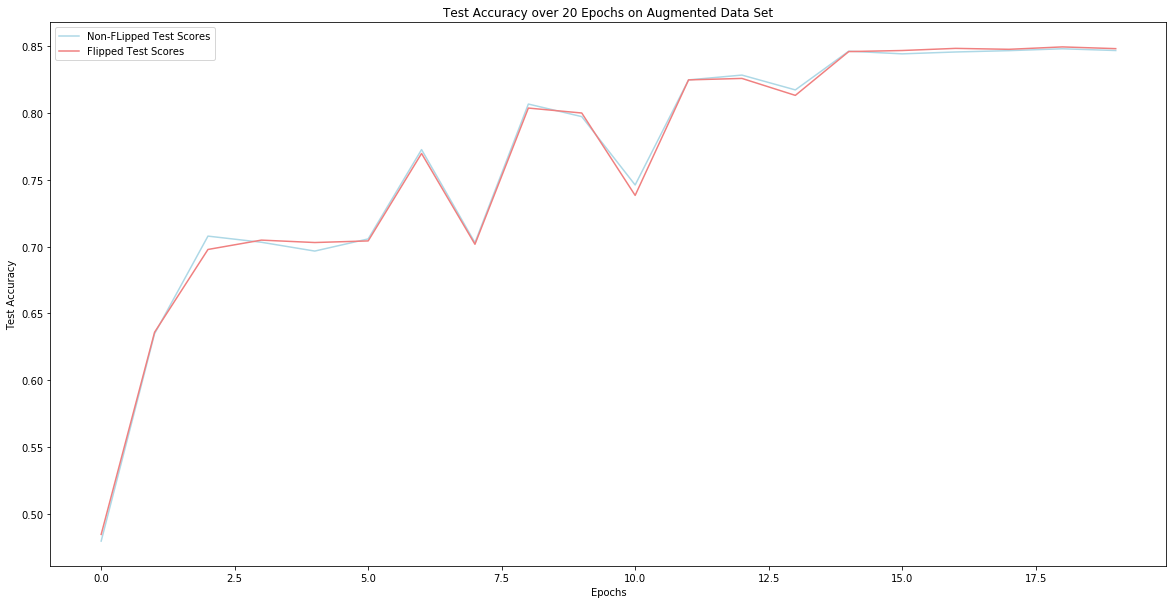

In [45]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 20
test_scores = []
flipped_test_scores = []
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate(model, test_dl)
    flipped_test_loss, flipped_test_acc = evaluate(model, flipped_test_dl)
    test_scores.append(test_acc)
    flipped_test_scores.append(flipped_test_acc)
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}')
fig = plt.figure(figsize = (20, 10))
plt.plot(test_scores, color= 'lightblue', label='Non-FLipped Test Scores')
plt.plot(flipped_test_scores, color='lightcoral', label='Flipped Test Scores')
plt.title('Test Accuracy over 20 Epochs on Augmented Data Set')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('Performances_after_20_epochs_data_augm.png')
plt.show(fig)

Starting Epoch 0


  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 7.295 	 Train Acc: 0.150
	 [Batch 100 / 1563] Train Loss: 4.875 	 Train Acc: 0.175
	 [Batch 150 / 1563] Train Loss: 3.991 	 Train Acc: 0.200
	 [Batch 200 / 1563] Train Loss: 3.507 	 Train Acc: 0.220
	 [Batch 250 / 1563] Train Loss: 3.207 	 Train Acc: 0.231
	 [Batch 300 / 1563] Train Loss: 2.989 	 Train Acc: 0.245
	 [Batch 350 / 1563] Train Loss: 2.822 	 Train Acc: 0.257
	 [Batch 400 / 1563] Train Loss: 2.688 	 Train Acc: 0.270
	 [Batch 450 / 1563] Train Loss: 2.580 	 Train Acc: 0.281
	 [Batch 500 / 1563] Train Loss: 2.494 	 Train Acc: 0.290
	 [Batch 550 / 1563] Train Loss: 2.419 	 Train Acc: 0.300
	 [Batch 600 / 1563] Train Loss: 2.351 	 Train Acc: 0.310
	 [Batch 650 / 1563] Train Loss: 2.290 	 Train Acc: 0.318
	 [Batch 700 / 1563] Train Loss: 2.236 	 Train Acc: 0.327
	 [Batch 750 / 1563] Train Loss: 2.187 	 Train Acc: 0.336
	 [Batch 800 / 1563] Train Loss: 2.145 	 Train Acc: 0.342
	 [Batch 850 / 1563] Train Loss: 2.105 	 Train Acc: 0.349
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 1.150 	 Train Acc: 0.580
	 [Batch 100 / 1563] Train Loss: 1.143 	 Train Acc: 0.591
	 [Batch 150 / 1563] Train Loss: 1.135 	 Train Acc: 0.596
	 [Batch 200 / 1563] Train Loss: 1.134 	 Train Acc: 0.597
	 [Batch 250 / 1563] Train Loss: 1.130 	 Train Acc: 0.600
	 [Batch 300 / 1563] Train Loss: 1.122 	 Train Acc: 0.602
	 [Batch 350 / 1563] Train Loss: 1.120 	 Train Acc: 0.600
	 [Batch 400 / 1563] Train Loss: 1.121 	 Train Acc: 0.600
	 [Batch 450 / 1563] Train Loss: 1.117 	 Train Acc: 0.601
	 [Batch 500 / 1563] Train Loss: 1.111 	 Train Acc: 0.603
	 [Batch 550 / 1563] Train Loss: 1.107 	 Train Acc: 0.604
	 [Batch 600 / 1563] Train Loss: 1.100 	 Train Acc: 0.608
	 [Batch 650 / 1563] Train Loss: 1.093 	 Train Acc: 0.610
	 [Batch 700 / 1563] Train Loss: 1.089 	 Train Acc: 0.613
	 [Batch 750 / 1563] Train Loss: 1.086 	 Train Acc: 0.614
	 [Batch 800 / 1563] Train Loss: 1.082 	 Train Acc: 0.615
	 [Batch 850 / 1563] Train Loss: 1.078 	 Train Acc: 0.616
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.880 	 Train Acc: 0.690
	 [Batch 100 / 1563] Train Loss: 0.856 	 Train Acc: 0.704
	 [Batch 150 / 1563] Train Loss: 0.850 	 Train Acc: 0.705
	 [Batch 200 / 1563] Train Loss: 0.857 	 Train Acc: 0.700
	 [Batch 250 / 1563] Train Loss: 0.850 	 Train Acc: 0.702
	 [Batch 300 / 1563] Train Loss: 0.847 	 Train Acc: 0.702
	 [Batch 350 / 1563] Train Loss: 0.847 	 Train Acc: 0.703
	 [Batch 400 / 1563] Train Loss: 0.844 	 Train Acc: 0.703
	 [Batch 450 / 1563] Train Loss: 0.844 	 Train Acc: 0.703
	 [Batch 500 / 1563] Train Loss: 0.844 	 Train Acc: 0.704
	 [Batch 550 / 1563] Train Loss: 0.841 	 Train Acc: 0.705
	 [Batch 600 / 1563] Train Loss: 0.841 	 Train Acc: 0.705
	 [Batch 650 / 1563] Train Loss: 0.839 	 Train Acc: 0.706
	 [Batch 700 / 1563] Train Loss: 0.837 	 Train Acc: 0.707
	 [Batch 750 / 1563] Train Loss: 0.836 	 Train Acc: 0.708
	 [Batch 800 / 1563] Train Loss: 0.834 	 Train Acc: 0.708
	 [Batch 850 / 1563] Train Loss: 0.832 	 Train Acc: 0.708
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.685 	 Train Acc: 0.757
	 [Batch 100 / 1563] Train Loss: 0.670 	 Train Acc: 0.766
	 [Batch 150 / 1563] Train Loss: 0.676 	 Train Acc: 0.765
	 [Batch 200 / 1563] Train Loss: 0.670 	 Train Acc: 0.768
	 [Batch 250 / 1563] Train Loss: 0.674 	 Train Acc: 0.767
	 [Batch 300 / 1563] Train Loss: 0.672 	 Train Acc: 0.767
	 [Batch 350 / 1563] Train Loss: 0.673 	 Train Acc: 0.766
	 [Batch 400 / 1563] Train Loss: 0.670 	 Train Acc: 0.765
	 [Batch 450 / 1563] Train Loss: 0.666 	 Train Acc: 0.766
	 [Batch 500 / 1563] Train Loss: 0.666 	 Train Acc: 0.766
	 [Batch 550 / 1563] Train Loss: 0.669 	 Train Acc: 0.766
	 [Batch 600 / 1563] Train Loss: 0.669 	 Train Acc: 0.765
	 [Batch 650 / 1563] Train Loss: 0.669 	 Train Acc: 0.765
	 [Batch 700 / 1563] Train Loss: 0.666 	 Train Acc: 0.767
	 [Batch 750 / 1563] Train Loss: 0.666 	 Train Acc: 0.767
	 [Batch 800 / 1563] Train Loss: 0.665 	 Train Acc: 0.767
	 [Batch 850 / 1563] Train Loss: 0.664 	 Train Acc: 0.768
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.549 	 Train Acc: 0.816
	 [Batch 100 / 1563] Train Loss: 0.567 	 Train Acc: 0.803
	 [Batch 150 / 1563] Train Loss: 0.573 	 Train Acc: 0.799
	 [Batch 200 / 1563] Train Loss: 0.564 	 Train Acc: 0.804
	 [Batch 250 / 1563] Train Loss: 0.561 	 Train Acc: 0.805
	 [Batch 300 / 1563] Train Loss: 0.557 	 Train Acc: 0.806
	 [Batch 350 / 1563] Train Loss: 0.563 	 Train Acc: 0.804
	 [Batch 400 / 1563] Train Loss: 0.561 	 Train Acc: 0.805
	 [Batch 450 / 1563] Train Loss: 0.558 	 Train Acc: 0.807
	 [Batch 500 / 1563] Train Loss: 0.558 	 Train Acc: 0.806
	 [Batch 550 / 1563] Train Loss: 0.559 	 Train Acc: 0.806
	 [Batch 600 / 1563] Train Loss: 0.557 	 Train Acc: 0.806
	 [Batch 650 / 1563] Train Loss: 0.562 	 Train Acc: 0.804
	 [Batch 700 / 1563] Train Loss: 0.562 	 Train Acc: 0.804
	 [Batch 750 / 1563] Train Loss: 0.561 	 Train Acc: 0.804
	 [Batch 800 / 1563] Train Loss: 0.560 	 Train Acc: 0.804
	 [Batch 850 / 1563] Train Loss: 0.558 	 Train Acc: 0.805
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.436 	 Train Acc: 0.851
	 [Batch 100 / 1563] Train Loss: 0.460 	 Train Acc: 0.840
	 [Batch 150 / 1563] Train Loss: 0.463 	 Train Acc: 0.838
	 [Batch 200 / 1563] Train Loss: 0.458 	 Train Acc: 0.840
	 [Batch 250 / 1563] Train Loss: 0.460 	 Train Acc: 0.839
	 [Batch 300 / 1563] Train Loss: 0.465 	 Train Acc: 0.836
	 [Batch 350 / 1563] Train Loss: 0.466 	 Train Acc: 0.836
	 [Batch 400 / 1563] Train Loss: 0.465 	 Train Acc: 0.837
	 [Batch 450 / 1563] Train Loss: 0.465 	 Train Acc: 0.837
	 [Batch 500 / 1563] Train Loss: 0.462 	 Train Acc: 0.838
	 [Batch 550 / 1563] Train Loss: 0.461 	 Train Acc: 0.838
	 [Batch 600 / 1563] Train Loss: 0.462 	 Train Acc: 0.838
	 [Batch 650 / 1563] Train Loss: 0.463 	 Train Acc: 0.838
	 [Batch 700 / 1563] Train Loss: 0.463 	 Train Acc: 0.837
	 [Batch 750 / 1563] Train Loss: 0.462 	 Train Acc: 0.838
	 [Batch 800 / 1563] Train Loss: 0.463 	 Train Acc: 0.837
	 [Batch 850 / 1563] Train Loss: 0.465 	 Train Acc: 0.837
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.339 	 Train Acc: 0.881
	 [Batch 100 / 1563] Train Loss: 0.352 	 Train Acc: 0.875
	 [Batch 150 / 1563] Train Loss: 0.357 	 Train Acc: 0.874
	 [Batch 200 / 1563] Train Loss: 0.368 	 Train Acc: 0.871
	 [Batch 250 / 1563] Train Loss: 0.373 	 Train Acc: 0.870
	 [Batch 300 / 1563] Train Loss: 0.375 	 Train Acc: 0.869
	 [Batch 350 / 1563] Train Loss: 0.377 	 Train Acc: 0.868
	 [Batch 400 / 1563] Train Loss: 0.376 	 Train Acc: 0.870
	 [Batch 450 / 1563] Train Loss: 0.376 	 Train Acc: 0.870
	 [Batch 500 / 1563] Train Loss: 0.376 	 Train Acc: 0.869
	 [Batch 550 / 1563] Train Loss: 0.378 	 Train Acc: 0.868
	 [Batch 600 / 1563] Train Loss: 0.378 	 Train Acc: 0.868
	 [Batch 650 / 1563] Train Loss: 0.381 	 Train Acc: 0.868
	 [Batch 700 / 1563] Train Loss: 0.382 	 Train Acc: 0.867
	 [Batch 750 / 1563] Train Loss: 0.382 	 Train Acc: 0.868
	 [Batch 800 / 1563] Train Loss: 0.381 	 Train Acc: 0.868
	 [Batch 850 / 1563] Train Loss: 0.382 	 Train Acc: 0.867
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.249 	 Train Acc: 0.914
	 [Batch 100 / 1563] Train Loss: 0.253 	 Train Acc: 0.914
	 [Batch 150 / 1563] Train Loss: 0.266 	 Train Acc: 0.911
	 [Batch 200 / 1563] Train Loss: 0.272 	 Train Acc: 0.908
	 [Batch 250 / 1563] Train Loss: 0.282 	 Train Acc: 0.903
	 [Batch 300 / 1563] Train Loss: 0.284 	 Train Acc: 0.902
	 [Batch 350 / 1563] Train Loss: 0.284 	 Train Acc: 0.902
	 [Batch 400 / 1563] Train Loss: 0.289 	 Train Acc: 0.901
	 [Batch 450 / 1563] Train Loss: 0.292 	 Train Acc: 0.899
	 [Batch 500 / 1563] Train Loss: 0.294 	 Train Acc: 0.898
	 [Batch 550 / 1563] Train Loss: 0.301 	 Train Acc: 0.895
	 [Batch 600 / 1563] Train Loss: 0.301 	 Train Acc: 0.896
	 [Batch 650 / 1563] Train Loss: 0.302 	 Train Acc: 0.896
	 [Batch 700 / 1563] Train Loss: 0.303 	 Train Acc: 0.895
	 [Batch 750 / 1563] Train Loss: 0.305 	 Train Acc: 0.894
	 [Batch 800 / 1563] Train Loss: 0.306 	 Train Acc: 0.893
	 [Batch 850 / 1563] Train Loss: 0.307 	 Train Acc: 0.893
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.234 	 Train Acc: 0.921
	 [Batch 100 / 1563] Train Loss: 0.212 	 Train Acc: 0.929
	 [Batch 150 / 1563] Train Loss: 0.208 	 Train Acc: 0.930
	 [Batch 200 / 1563] Train Loss: 0.221 	 Train Acc: 0.926
	 [Batch 250 / 1563] Train Loss: 0.218 	 Train Acc: 0.928
	 [Batch 300 / 1563] Train Loss: 0.215 	 Train Acc: 0.928
	 [Batch 350 / 1563] Train Loss: 0.215 	 Train Acc: 0.928
	 [Batch 400 / 1563] Train Loss: 0.224 	 Train Acc: 0.924
	 [Batch 450 / 1563] Train Loss: 0.225 	 Train Acc: 0.924
	 [Batch 500 / 1563] Train Loss: 0.228 	 Train Acc: 0.922
	 [Batch 550 / 1563] Train Loss: 0.227 	 Train Acc: 0.922
	 [Batch 600 / 1563] Train Loss: 0.227 	 Train Acc: 0.922
	 [Batch 650 / 1563] Train Loss: 0.228 	 Train Acc: 0.921
	 [Batch 700 / 1563] Train Loss: 0.230 	 Train Acc: 0.921
	 [Batch 750 / 1563] Train Loss: 0.231 	 Train Acc: 0.920
	 [Batch 800 / 1563] Train Loss: 0.235 	 Train Acc: 0.919
	 [Batch 850 / 1563] Train Loss: 0.236 	 Train Acc: 0.919
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.148 	 Train Acc: 0.946
	 [Batch 100 / 1563] Train Loss: 0.152 	 Train Acc: 0.946
	 [Batch 150 / 1563] Train Loss: 0.151 	 Train Acc: 0.947
	 [Batch 200 / 1563] Train Loss: 0.151 	 Train Acc: 0.948
	 [Batch 250 / 1563] Train Loss: 0.150 	 Train Acc: 0.947
	 [Batch 300 / 1563] Train Loss: 0.157 	 Train Acc: 0.945
	 [Batch 350 / 1563] Train Loss: 0.162 	 Train Acc: 0.944
	 [Batch 400 / 1563] Train Loss: 0.159 	 Train Acc: 0.944
	 [Batch 450 / 1563] Train Loss: 0.159 	 Train Acc: 0.944
	 [Batch 500 / 1563] Train Loss: 0.161 	 Train Acc: 0.944
	 [Batch 550 / 1563] Train Loss: 0.164 	 Train Acc: 0.942
	 [Batch 600 / 1563] Train Loss: 0.162 	 Train Acc: 0.943
	 [Batch 650 / 1563] Train Loss: 0.165 	 Train Acc: 0.942
	 [Batch 700 / 1563] Train Loss: 0.165 	 Train Acc: 0.942
	 [Batch 750 / 1563] Train Loss: 0.165 	 Train Acc: 0.942
	 [Batch 800 / 1563] Train Loss: 0.165 	 Train Acc: 0.942
	 [Batch 850 / 1563] Train Loss: 0.165 	 Train Acc: 0.942
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.111 	 Train Acc: 0.961
	 [Batch 100 / 1563] Train Loss: 0.104 	 Train Acc: 0.964
	 [Batch 150 / 1563] Train Loss: 0.099 	 Train Acc: 0.966
	 [Batch 200 / 1563] Train Loss: 0.096 	 Train Acc: 0.967
	 [Batch 250 / 1563] Train Loss: 0.097 	 Train Acc: 0.967
	 [Batch 300 / 1563] Train Loss: 0.097 	 Train Acc: 0.967
	 [Batch 350 / 1563] Train Loss: 0.098 	 Train Acc: 0.967
	 [Batch 400 / 1563] Train Loss: 0.101 	 Train Acc: 0.966
	 [Batch 450 / 1563] Train Loss: 0.103 	 Train Acc: 0.966
	 [Batch 500 / 1563] Train Loss: 0.107 	 Train Acc: 0.964
	 [Batch 550 / 1563] Train Loss: 0.107 	 Train Acc: 0.964
	 [Batch 600 / 1563] Train Loss: 0.108 	 Train Acc: 0.963
	 [Batch 650 / 1563] Train Loss: 0.109 	 Train Acc: 0.963
	 [Batch 700 / 1563] Train Loss: 0.111 	 Train Acc: 0.962
	 [Batch 750 / 1563] Train Loss: 0.113 	 Train Acc: 0.962
	 [Batch 800 / 1563] Train Loss: 0.115 	 Train Acc: 0.961
	 [Batch 850 / 1563] Train Loss: 0.115 	 Train Acc: 0.961
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.062 	 Train Acc: 0.980
	 [Batch 100 / 1563] Train Loss: 0.068 	 Train Acc: 0.977
	 [Batch 150 / 1563] Train Loss: 0.062 	 Train Acc: 0.980
	 [Batch 200 / 1563] Train Loss: 0.061 	 Train Acc: 0.981
	 [Batch 250 / 1563] Train Loss: 0.061 	 Train Acc: 0.981
	 [Batch 300 / 1563] Train Loss: 0.059 	 Train Acc: 0.982
	 [Batch 350 / 1563] Train Loss: 0.058 	 Train Acc: 0.982
	 [Batch 400 / 1563] Train Loss: 0.058 	 Train Acc: 0.983
	 [Batch 450 / 1563] Train Loss: 0.057 	 Train Acc: 0.983
	 [Batch 500 / 1563] Train Loss: 0.058 	 Train Acc: 0.983
	 [Batch 550 / 1563] Train Loss: 0.059 	 Train Acc: 0.982
	 [Batch 600 / 1563] Train Loss: 0.060 	 Train Acc: 0.982
	 [Batch 650 / 1563] Train Loss: 0.060 	 Train Acc: 0.981
	 [Batch 700 / 1563] Train Loss: 0.060 	 Train Acc: 0.982
	 [Batch 750 / 1563] Train Loss: 0.060 	 Train Acc: 0.982
	 [Batch 800 / 1563] Train Loss: 0.061 	 Train Acc: 0.981
	 [Batch 850 / 1563] Train Loss: 0.061 	 Train Acc: 0.981
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.056 	 Train Acc: 0.984
	 [Batch 100 / 1563] Train Loss: 0.051 	 Train Acc: 0.985
	 [Batch 150 / 1563] Train Loss: 0.046 	 Train Acc: 0.987
	 [Batch 200 / 1563] Train Loss: 0.047 	 Train Acc: 0.987
	 [Batch 250 / 1563] Train Loss: 0.046 	 Train Acc: 0.988
	 [Batch 300 / 1563] Train Loss: 0.044 	 Train Acc: 0.988
	 [Batch 350 / 1563] Train Loss: 0.043 	 Train Acc: 0.988
	 [Batch 400 / 1563] Train Loss: 0.043 	 Train Acc: 0.988
	 [Batch 450 / 1563] Train Loss: 0.043 	 Train Acc: 0.988
	 [Batch 500 / 1563] Train Loss: 0.043 	 Train Acc: 0.988
	 [Batch 550 / 1563] Train Loss: 0.042 	 Train Acc: 0.989
	 [Batch 600 / 1563] Train Loss: 0.042 	 Train Acc: 0.989
	 [Batch 650 / 1563] Train Loss: 0.041 	 Train Acc: 0.989
	 [Batch 700 / 1563] Train Loss: 0.040 	 Train Acc: 0.989
	 [Batch 750 / 1563] Train Loss: 0.040 	 Train Acc: 0.989
	 [Batch 800 / 1563] Train Loss: 0.040 	 Train Acc: 0.989
	 [Batch 850 / 1563] Train Loss: 0.040 	 Train Acc: 0.989
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.024 	 Train Acc: 0.997
	 [Batch 100 / 1563] Train Loss: 0.022 	 Train Acc: 0.996
	 [Batch 150 / 1563] Train Loss: 0.023 	 Train Acc: 0.996
	 [Batch 200 / 1563] Train Loss: 0.022 	 Train Acc: 0.996
	 [Batch 250 / 1563] Train Loss: 0.020 	 Train Acc: 0.996
	 [Batch 300 / 1563] Train Loss: 0.020 	 Train Acc: 0.996
	 [Batch 350 / 1563] Train Loss: 0.019 	 Train Acc: 0.996
	 [Batch 400 / 1563] Train Loss: 0.020 	 Train Acc: 0.996
	 [Batch 450 / 1563] Train Loss: 0.020 	 Train Acc: 0.996
	 [Batch 500 / 1563] Train Loss: 0.020 	 Train Acc: 0.996
	 [Batch 550 / 1563] Train Loss: 0.020 	 Train Acc: 0.996
	 [Batch 600 / 1563] Train Loss: 0.019 	 Train Acc: 0.996
	 [Batch 650 / 1563] Train Loss: 0.019 	 Train Acc: 0.996
	 [Batch 700 / 1563] Train Loss: 0.019 	 Train Acc: 0.997
	 [Batch 750 / 1563] Train Loss: 0.018 	 Train Acc: 0.997
	 [Batch 800 / 1563] Train Loss: 0.018 	 Train Acc: 0.997
	 [Batch 850 / 1563] Train Loss: 0.018 	 Train Acc: 0.997
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.007 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 150 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 200 / 1563] Train Loss: 0.008 	 Train Acc: 0.999
	 [Batch 250 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 300 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 350 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 400 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 450 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 500 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 550 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 600 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 650 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 700 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 750 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 800 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 850 / 1563] Train Loss: 0.007 	 Train Acc: 0.999
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.001 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

  0%|          | 0/1563 [00:00<?, ?it/s]

	 [Batch 50 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 100 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 150 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 200 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 250 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 300 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 350 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 400 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 450 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 500 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 550 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 600 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 650 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 700 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 750 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 800 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 850 / 1563] Train Loss: 0.000 	 Train Acc: 1.000
	 [Batch 900 / 

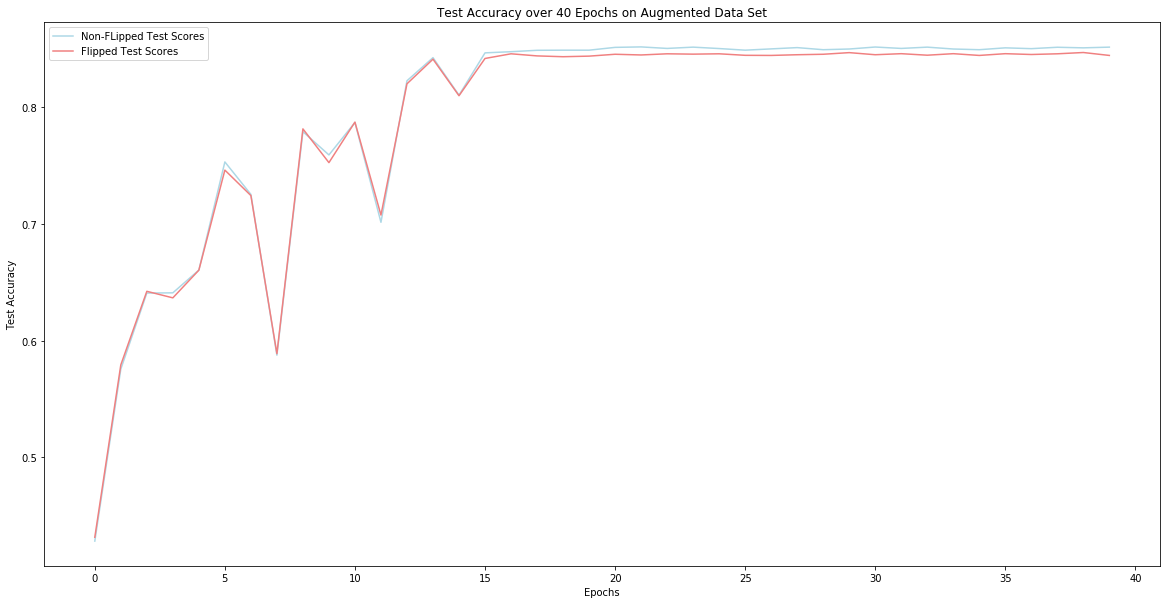

In [6]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 40
test_scores = []
flipped_test_scores = []
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate(model, test_dl)
    flipped_test_loss, flipped_test_acc = evaluate(model, flipped_test_dl)
    test_scores.append(test_acc)
    flipped_test_scores.append(flipped_test_acc)
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}')
fig = plt.figure(figsize = (20, 10))
plt.plot(test_scores, color= 'lightblue', label='Non-FLipped Test Scores')
plt.plot(flipped_test_scores, color='lightcoral', label='Flipped Test Scores')
plt.title('Test Accuracy over 40 Epochs on Augmented Data Set')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('Performances_after_40_epochs_data_augm.png')
plt.show(fig)